In [1]:
!git clone https://github.com/SamsungSAILMontreal/ForestDiffusion
!pip install ForestDiffusion
!mkdir Practice
!cp /kaggle/input/creditcardfraud/creditcard.csv Practice/

Cloning into 'ForestDiffusion'...
remote: Enumerating objects: 447, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 447 (delta 82), reused 129 (delta 72), pack-reused 299 (from 1)
Receiving objects: 100% (447/447), 901.47 KiB | 4.85 MiB/s, done.
Resolving deltas: 100% (215/215), done.


# #Distribution of all classes; Before and after augmentation

Class distribution before augmentation: {0: 284315, 1: 492}


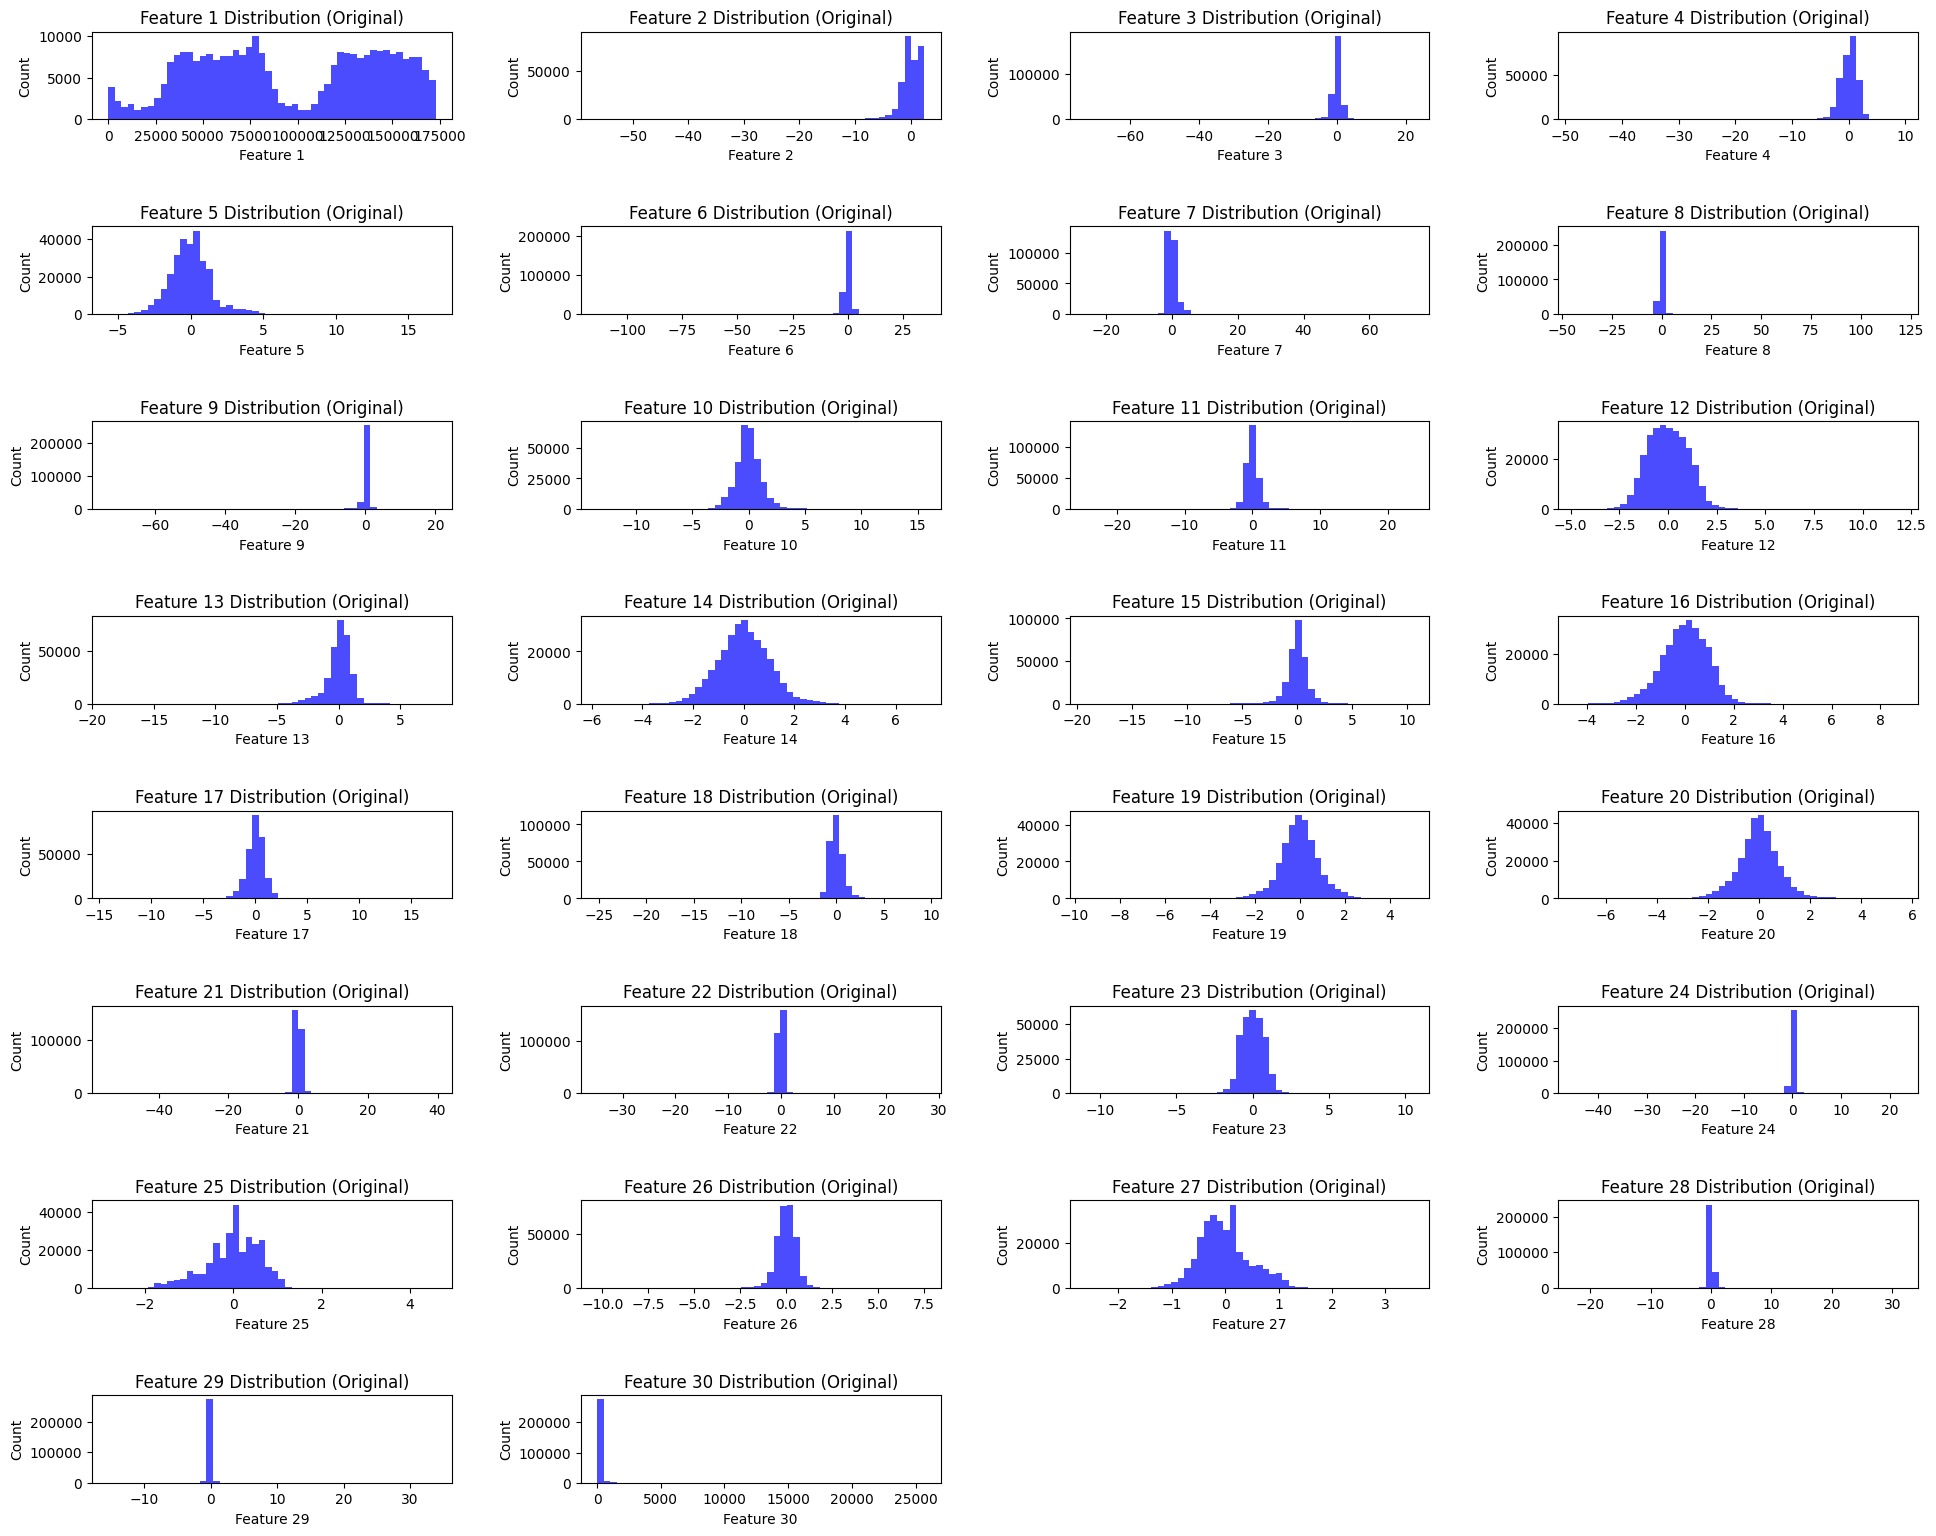

Class distribution after augmentation: {0.0: 284315, 1.0: 6188}


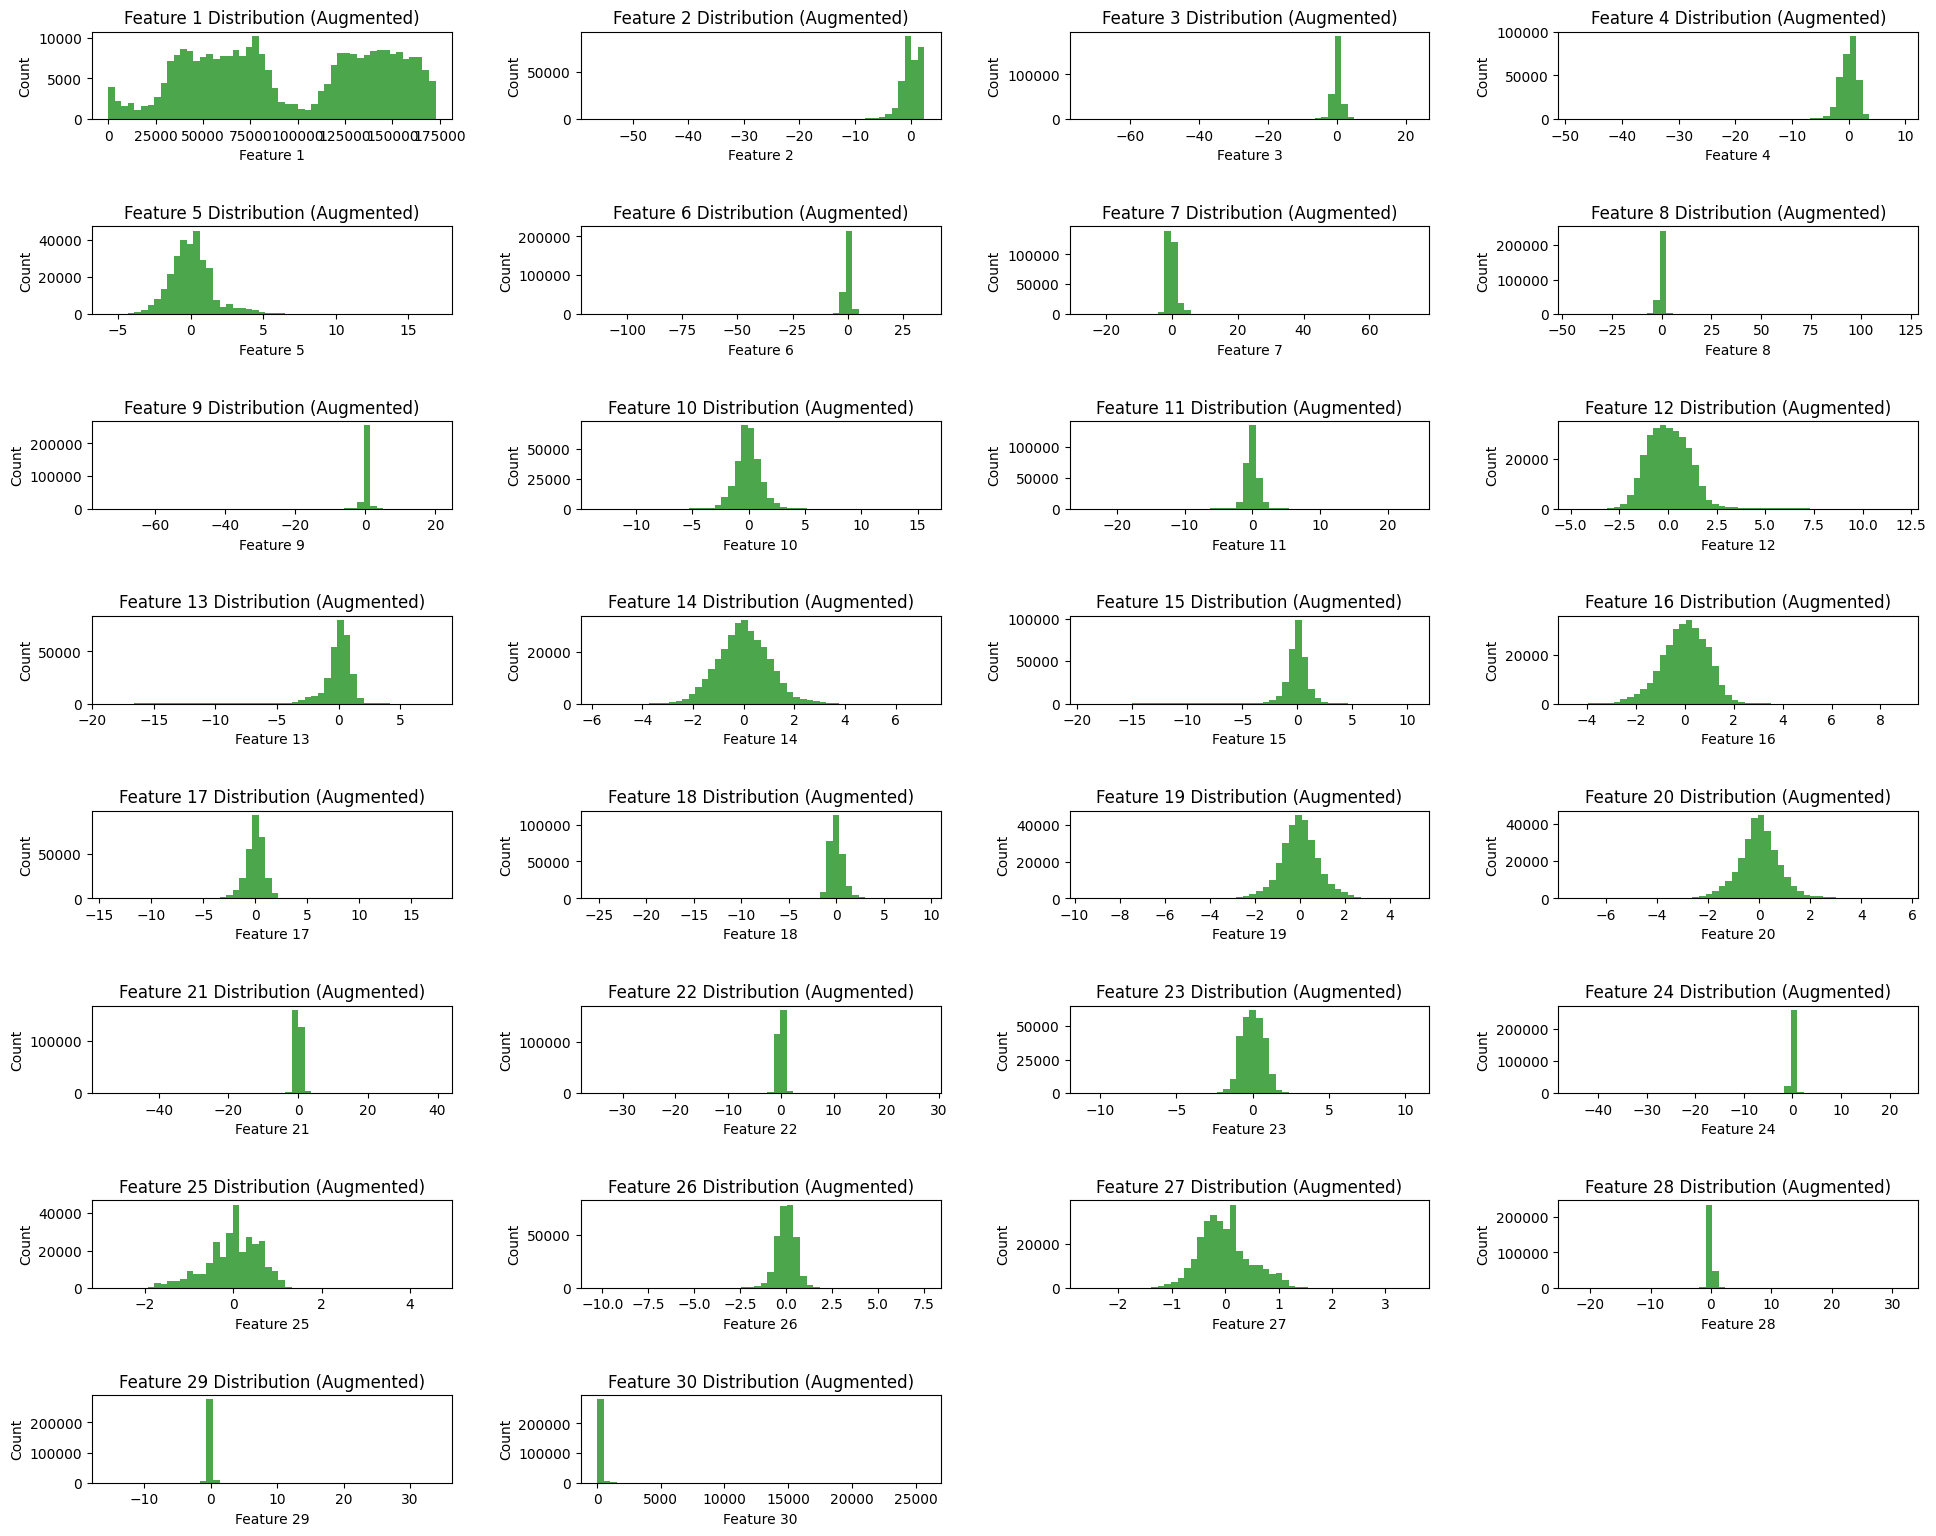


Training Support Vector Machine...


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.svm import SVC

# Step 1: Load the CSV file
file_path = '/kaggle/working/Practice/creditcard.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Plot the original imbalanced data (all features for visualization)
plt.figure(figsize=(20, 16))  # Increase figure size to make plots clearer
num_features = X.shape[1]
cols = 4  # Number of columns (4 plots per row)
rows = (num_features + cols - 1) // cols  # Calculate the number of rows

# Plot each feature distribution before augmentation
for i in range(num_features):
    plt.subplot(rows, cols, i + 1)  # Organize into 4 plots per row
    plt.hist(X[:, i], bins=50, alpha=0.7, color='blue', label='Original')
    plt.title(f'Feature {i+1} Distribution (Original)', fontsize=12)
    plt.xlabel(f'Feature {i+1}', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.tight_layout(pad=3.0)  # Adjust padding for better spacing

plt.show()

# Separate the minority class
X_minority = X[y == 1]

# Step 4: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X) // 50)

# Add generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 5: Plot the augmented data (all features for visualization)
plt.figure(figsize=(20, 16))  # Same large figure size for augmented data
# Plot each feature distribution after augmentation
for i in range(num_features):
    plt.subplot(rows, cols, i + 1)  # Organize into 4 plots per row
    plt.hist(X_balanced[:, i], bins=50, alpha=0.7, color='green', label='Balanced')
    plt.title(f'Feature {i+1} Distribution (Augmented)', fontsize=12)
    plt.xlabel(f'Feature {i+1}', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.tight_layout(pad=3.0)  # Adjust padding for better spacing

plt.show()

# Step 6: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 7: Define Support Vector Classifier with class_weight = balanced
classifier = SVC(class_weight='balanced')

# Step 8: Train and evaluate the classifier
print(f"\nTraining Support Vector Machine...")

# Train on original data
classifier.fit(X_train_orig, y_train_orig)
y_pred_orig = classifier.predict(X_test_orig)

# Train on balanced data
classifier.fit(X_train_bal, y_train_bal)
y_pred_bal = classifier.predict(X_test_bal)

# Calculate recall and F1 scores
recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_bal, y_pred_bal)
f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_bal, y_pred_bal)

# Print the performance metrics
print(f"Support Vector Machine - Recall (original): {recall_orig:.4f}, Recall (generated): {recall_bal:.4f}")
print(f"Support Vector Machine - F1 (original): {f1_orig:.4f}, F1 (generated): {f1_bal:.4f}")

# Step 9: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Step 1: Load the CSV file
file_path = '/kaggle/working/Practice/creditcard.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Separate the minority class
X_minority = X[y == 1]

# Step 4: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X) // 50)

# Add generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 5: Plot original vs augmented data for each feature side by side
plt.figure(figsize=(24, 20))  # Increase figure size for better visualization
num_features = X.shape[1]
cols = 2  # Two plots per row (original and augmented side by side)
rows = (num_features + 1) // cols  # Calculate number of rows

# Adjust the number of rows if needed to prevent subplot index error
if rows * cols < num_features * 2:
    rows = (num_features + 1) // 2

# Plot each feature's distribution for both original and augmented datasets
for i in range(num_features):
    plt.subplot(rows, cols, 2 * i + 1)  # Plot for original data
    plt.hist(X[:, i], bins=50, alpha=0.7, color='blue', label='Original')
    plt.title(f'Feature {i+1} (Original)', fontsize=14)
    plt.xlabel(f'Feature {i+1}', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    plt.subplot(rows, cols, 2 * i + 2)  # Plot for augmented data
    plt.hist(X_balanced[:, i], bins=50, alpha=0.7, color='green', label='Augmented')
    plt.title(f'Feature {i+1} (Augmented)', fontsize=14)
    plt.xlabel(f'Feature {i+1}', fontsize=12)
    plt.ylabel('Count', fontsize=12)

plt.tight_layout(pad=3.0)  # Adjust padding for better spacing
plt.show()

# Step 6: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 7: Scale the features
scaler = StandardScaler()

# Fit scaler on the original and balanced datasets
X_train_orig_scaled = scaler.fit_transform(X_train_orig)
X_test_orig_scaled = scaler.transform(X_test_orig)
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_bal_scaled = scaler.transform(X_test_bal)

# Step 8: Define Random Forest Classifier
classifier = RandomForestClassifier(class_weight='balanced')

# Step 9: Train and evaluate the classifier using scaled data
print(f"\nTraining Random Forest Classifier with scaled data...")

# Train on original scaled data
classifier.fit(X_train_orig_scaled, y_train_orig)
y_pred_orig = classifier.predict(X_test_orig_scaled)

# Train on balanced scaled data
classifier.fit(X_train_bal_scaled, y_train_bal)
y_pred_bal = classifier.predict(X_test_bal_scaled)

# Calculate recall and F1 scores
recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_bal, y_pred_bal)
f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_bal, y_pred_bal)

# Print the performance metrics
print(f"Random Forest - Recall (original): {recall_orig:.4f}, Recall (generated): {recall_bal:.4f}")
print(f"Random Forest - F1 (original): {f1_orig:.4f}, F1 (generated): {f1_bal:.4f}")

# Step 10: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")


Class distribution before augmentation: {0: 284315, 1: 492}
Class distribution after augmentation: {0.0: 284315, 1.0: 6188}


# Minority class distribution; Before and after augmentation

Class distribution before augmentation: {0: 284315, 1: 492}


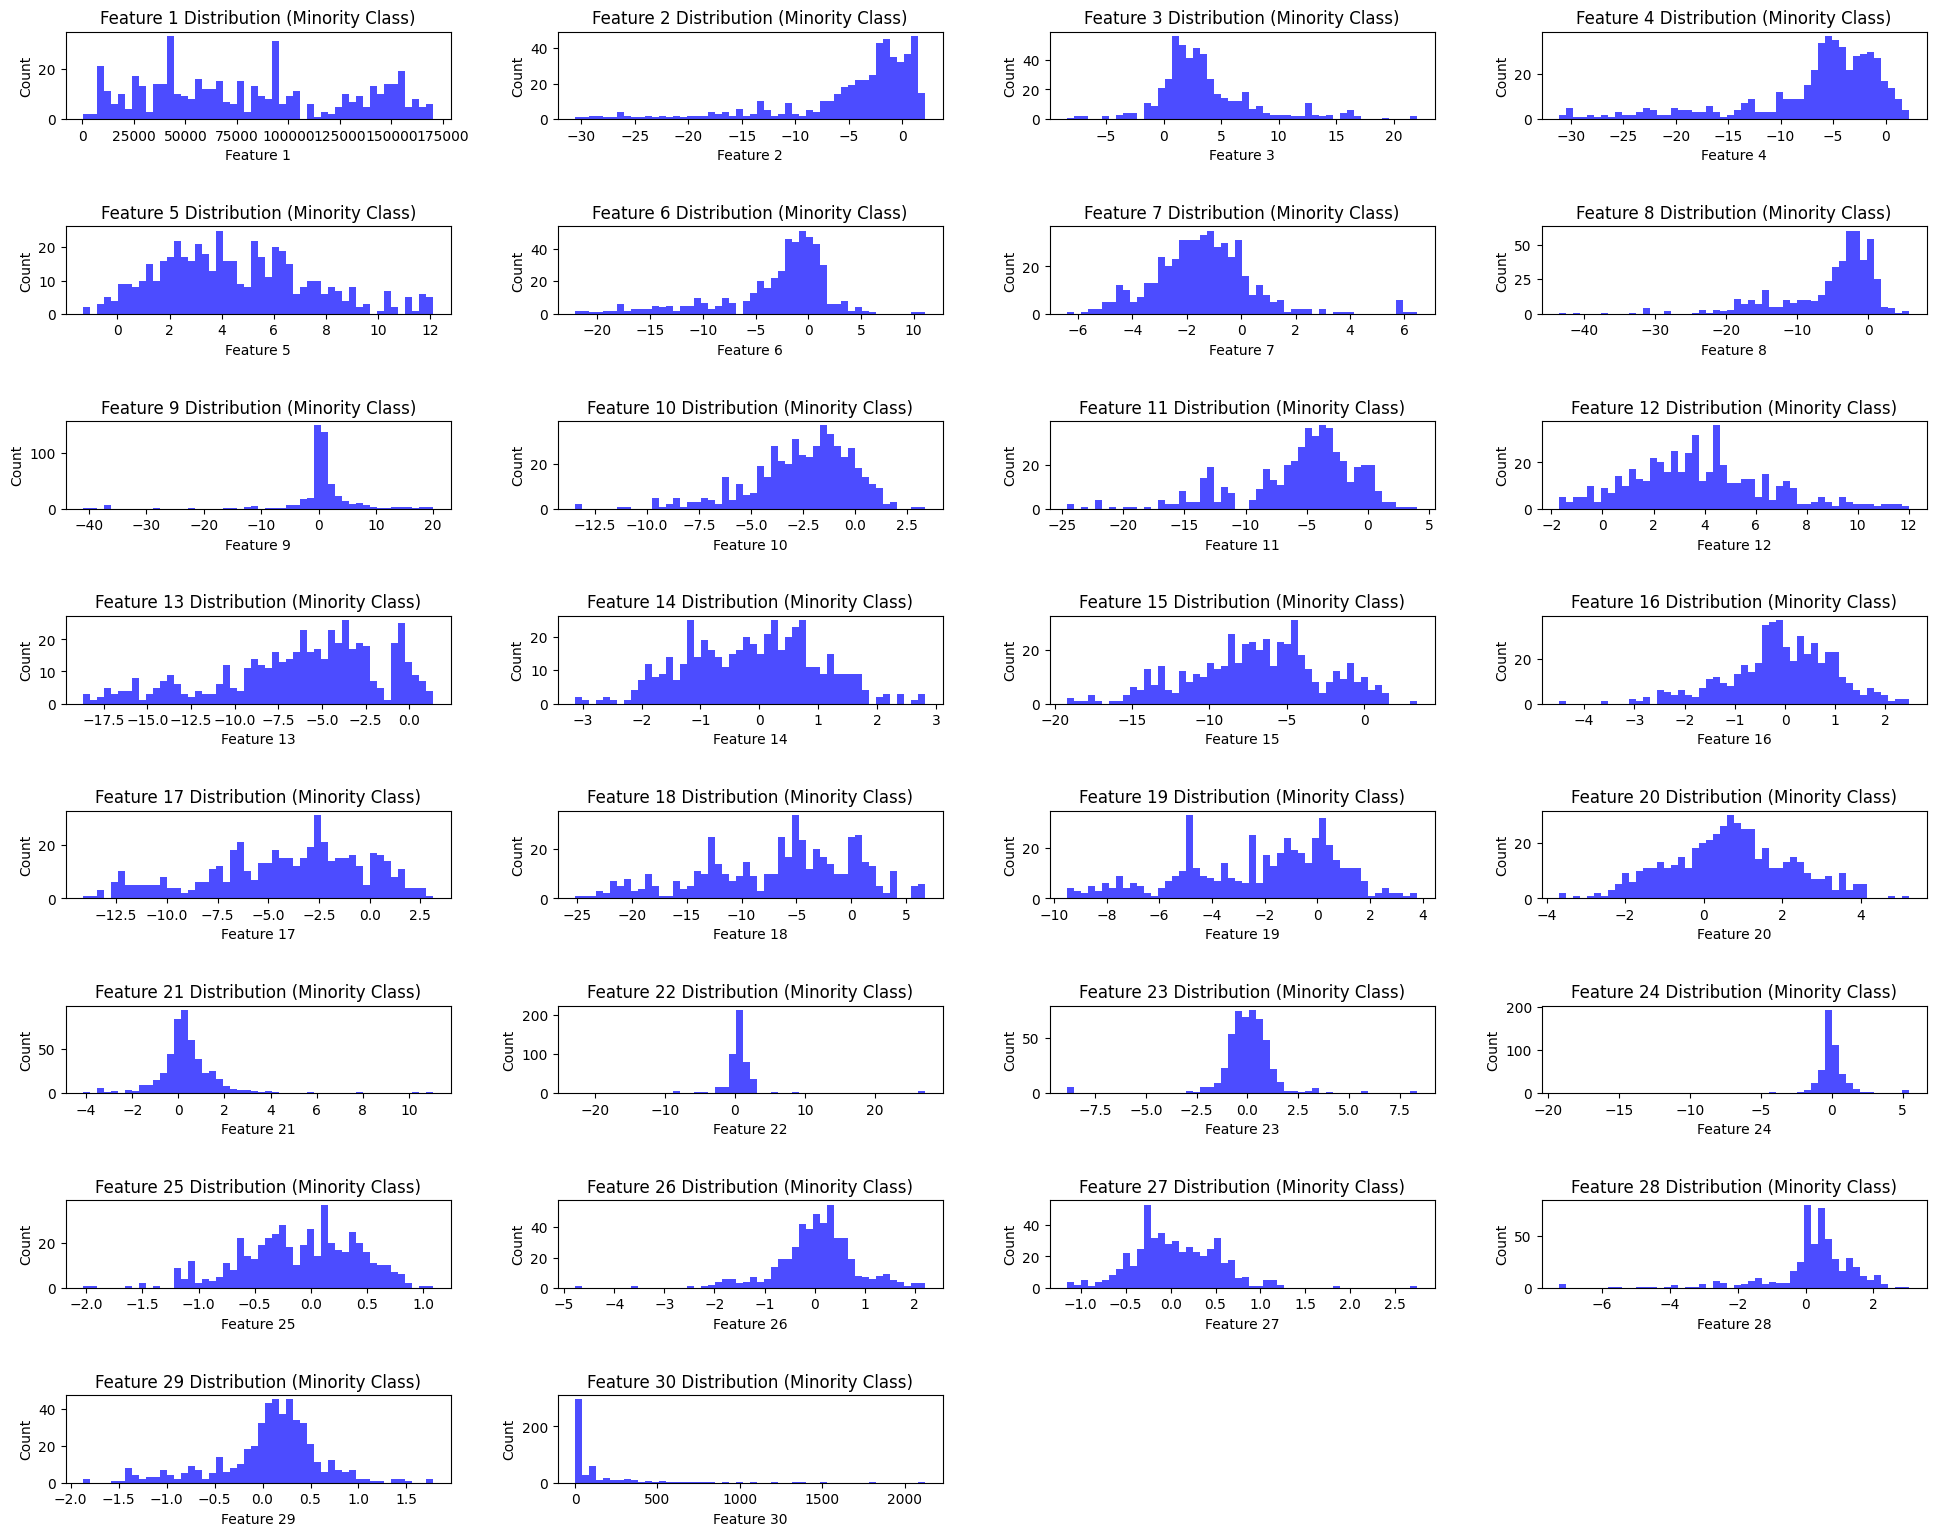

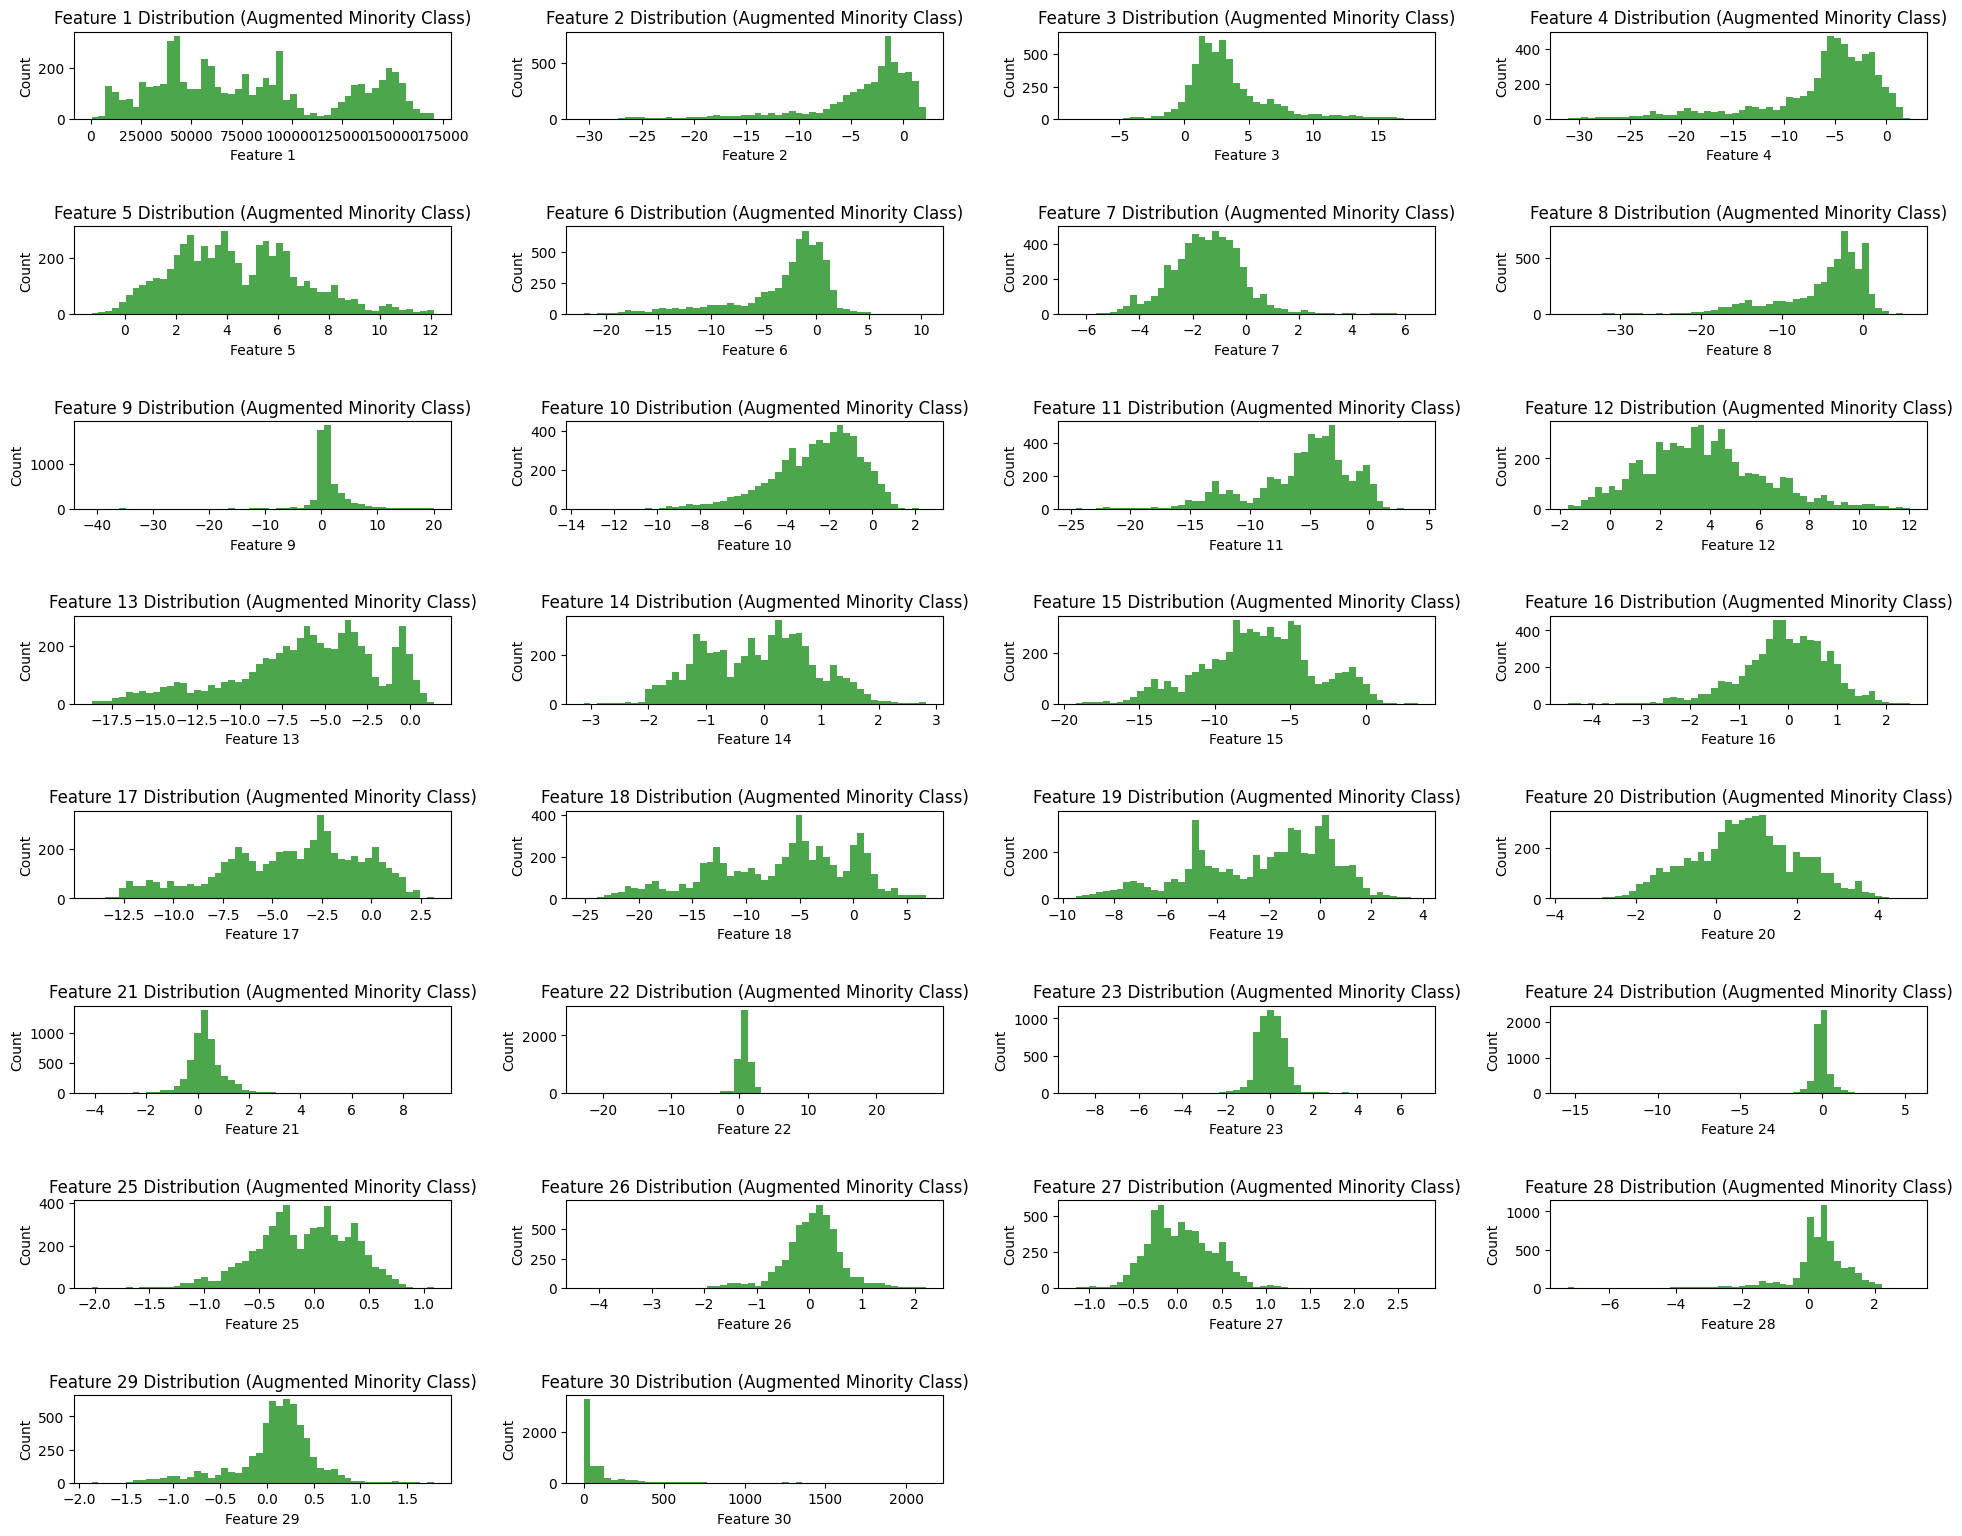

Class distribution after augmentation: {0.0: 284315, 1.0: 6188}

Training Logistic Regression on original data...
Training Logistic Regression on balanced data...
Logistic Regression - Recall (original): 0.6029, Recall (generated): 0.8485
Logistic Regression - F1 (original): 0.6920, F1 (generated): 0.8951
Number of fake samples generated: 5696


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.linear_model import LogisticRegression

# Step 1: Load the CSV file
file_path = '/kaggle/working/Practice/creditcard.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Separate the minority class
X_minority = X[y == 1]

# Step 3: Plot the minority class before augmentation (all features)
plt.figure(figsize=(20, 16))  # Large figure size for clarity
num_features = X_minority.shape[1]
cols = 4  # 4 plots per row
rows = (num_features + cols - 1) // cols  # Calculate the number of rows

for i in range(num_features):
    plt.subplot(rows, cols, i + 1)
    plt.hist(X_minority[:, i], bins=50, alpha=0.7, color='blue', label='Minority Class (Original)')
    plt.title(f'Feature {i+1} Distribution (Minority Class)', fontsize=12)
    plt.xlabel(f'Feature {i+1}', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.tight_layout(pad=3.0)  # Adjust padding

plt.show()

# Step 4: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X) // 50)

# Step 5: Plot the augmented minority class (all features)
plt.figure(figsize=(20, 16))  # Same large figure size for augmented data
for i in range(num_features):
    plt.subplot(rows, cols, i + 1)
    plt.hist(X_minority_fake[:, i], bins=50, alpha=0.7, color='green', label='Minority Class (Augmented)')
    plt.title(f'Feature {i+1} Distribution (Augmented Minority Class)', fontsize=12)
    plt.xlabel(f'Feature {i+1}', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.tight_layout(pad=3.0)  # Adjust padding

plt.show()

# Check and print the class distribution after augmentation
X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 6: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 7: Train and evaluate Logistic Regression classifier
clf = LogisticRegression(max_iter=1000)

# Train on original data
print("\nTraining Logistic Regression on original data...")
clf.fit(X_train_orig, y_train_orig)
y_pred_orig = clf.predict(X_test_orig)

# Train on balanced data
print("Training Logistic Regression on balanced data...")
clf.fit(X_train_bal, y_train_bal)
y_pred_bal = clf.predict(X_test_bal)

# Step 8: Calculate recall and F1 scores
recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_bal, y_pred_bal)
f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_bal, y_pred_bal)

# Print the performance metrics
print(f"Logistic Regression - Recall (original): {recall_orig:.4f}, Recall (generated): {recall_bal:.4f}")
print(f"Logistic Regression - F1 (original): {f1_orig:.4f}, F1 (generated): {f1_bal:.4f}")

# Step 9: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")


# #Distribution using RandomForestClassifier

Class distribution before augmentation: {0: 284315, 1: 492}


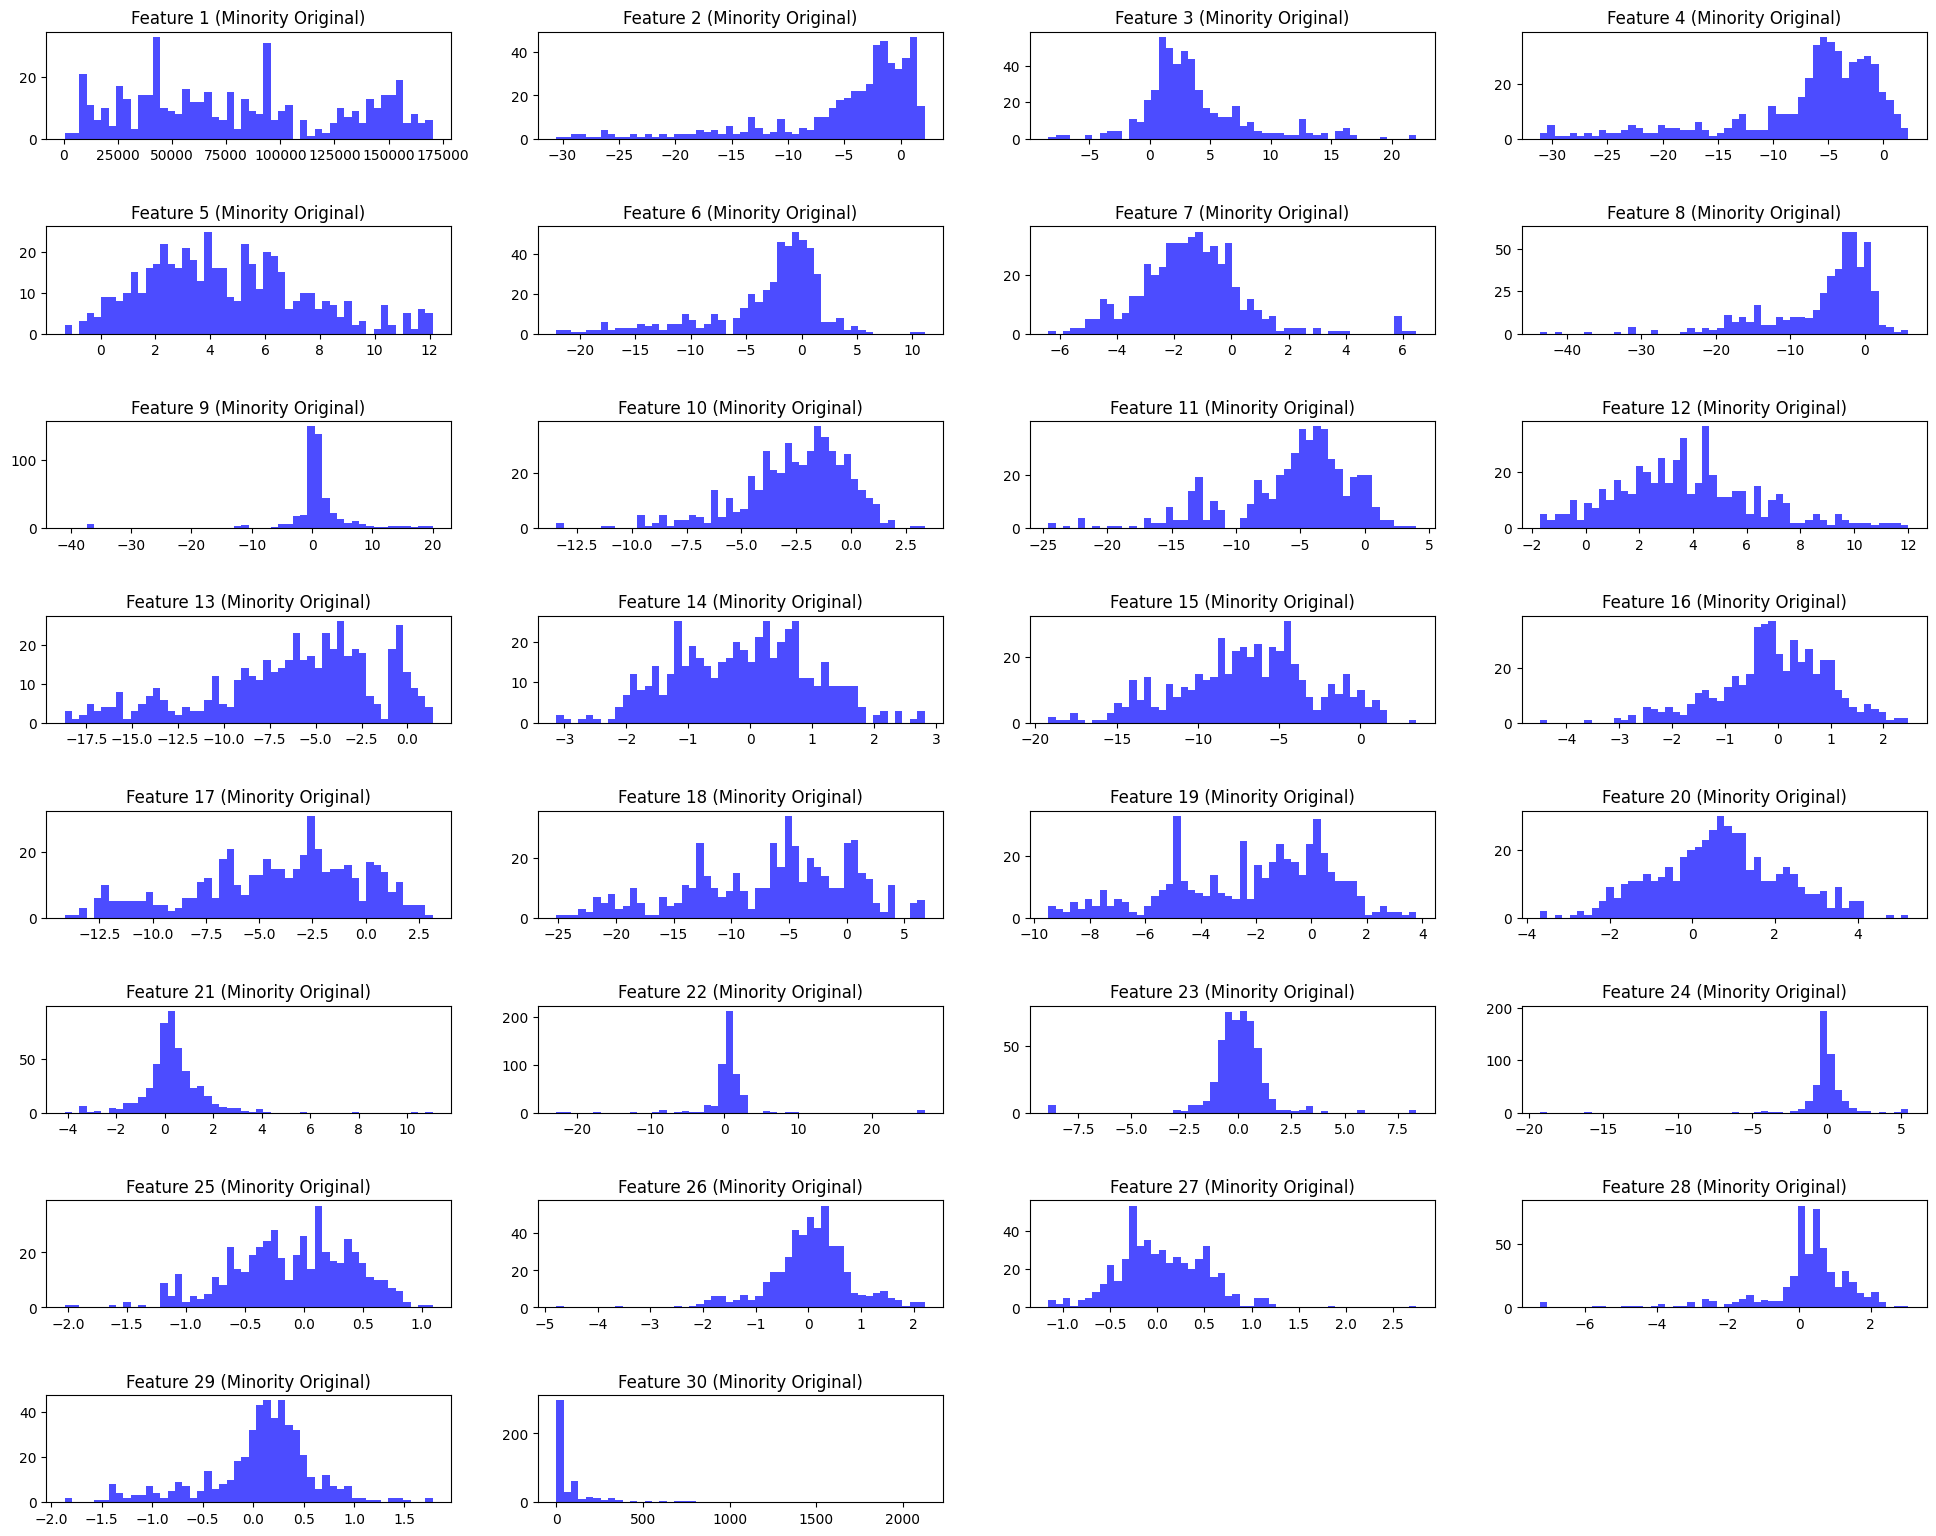

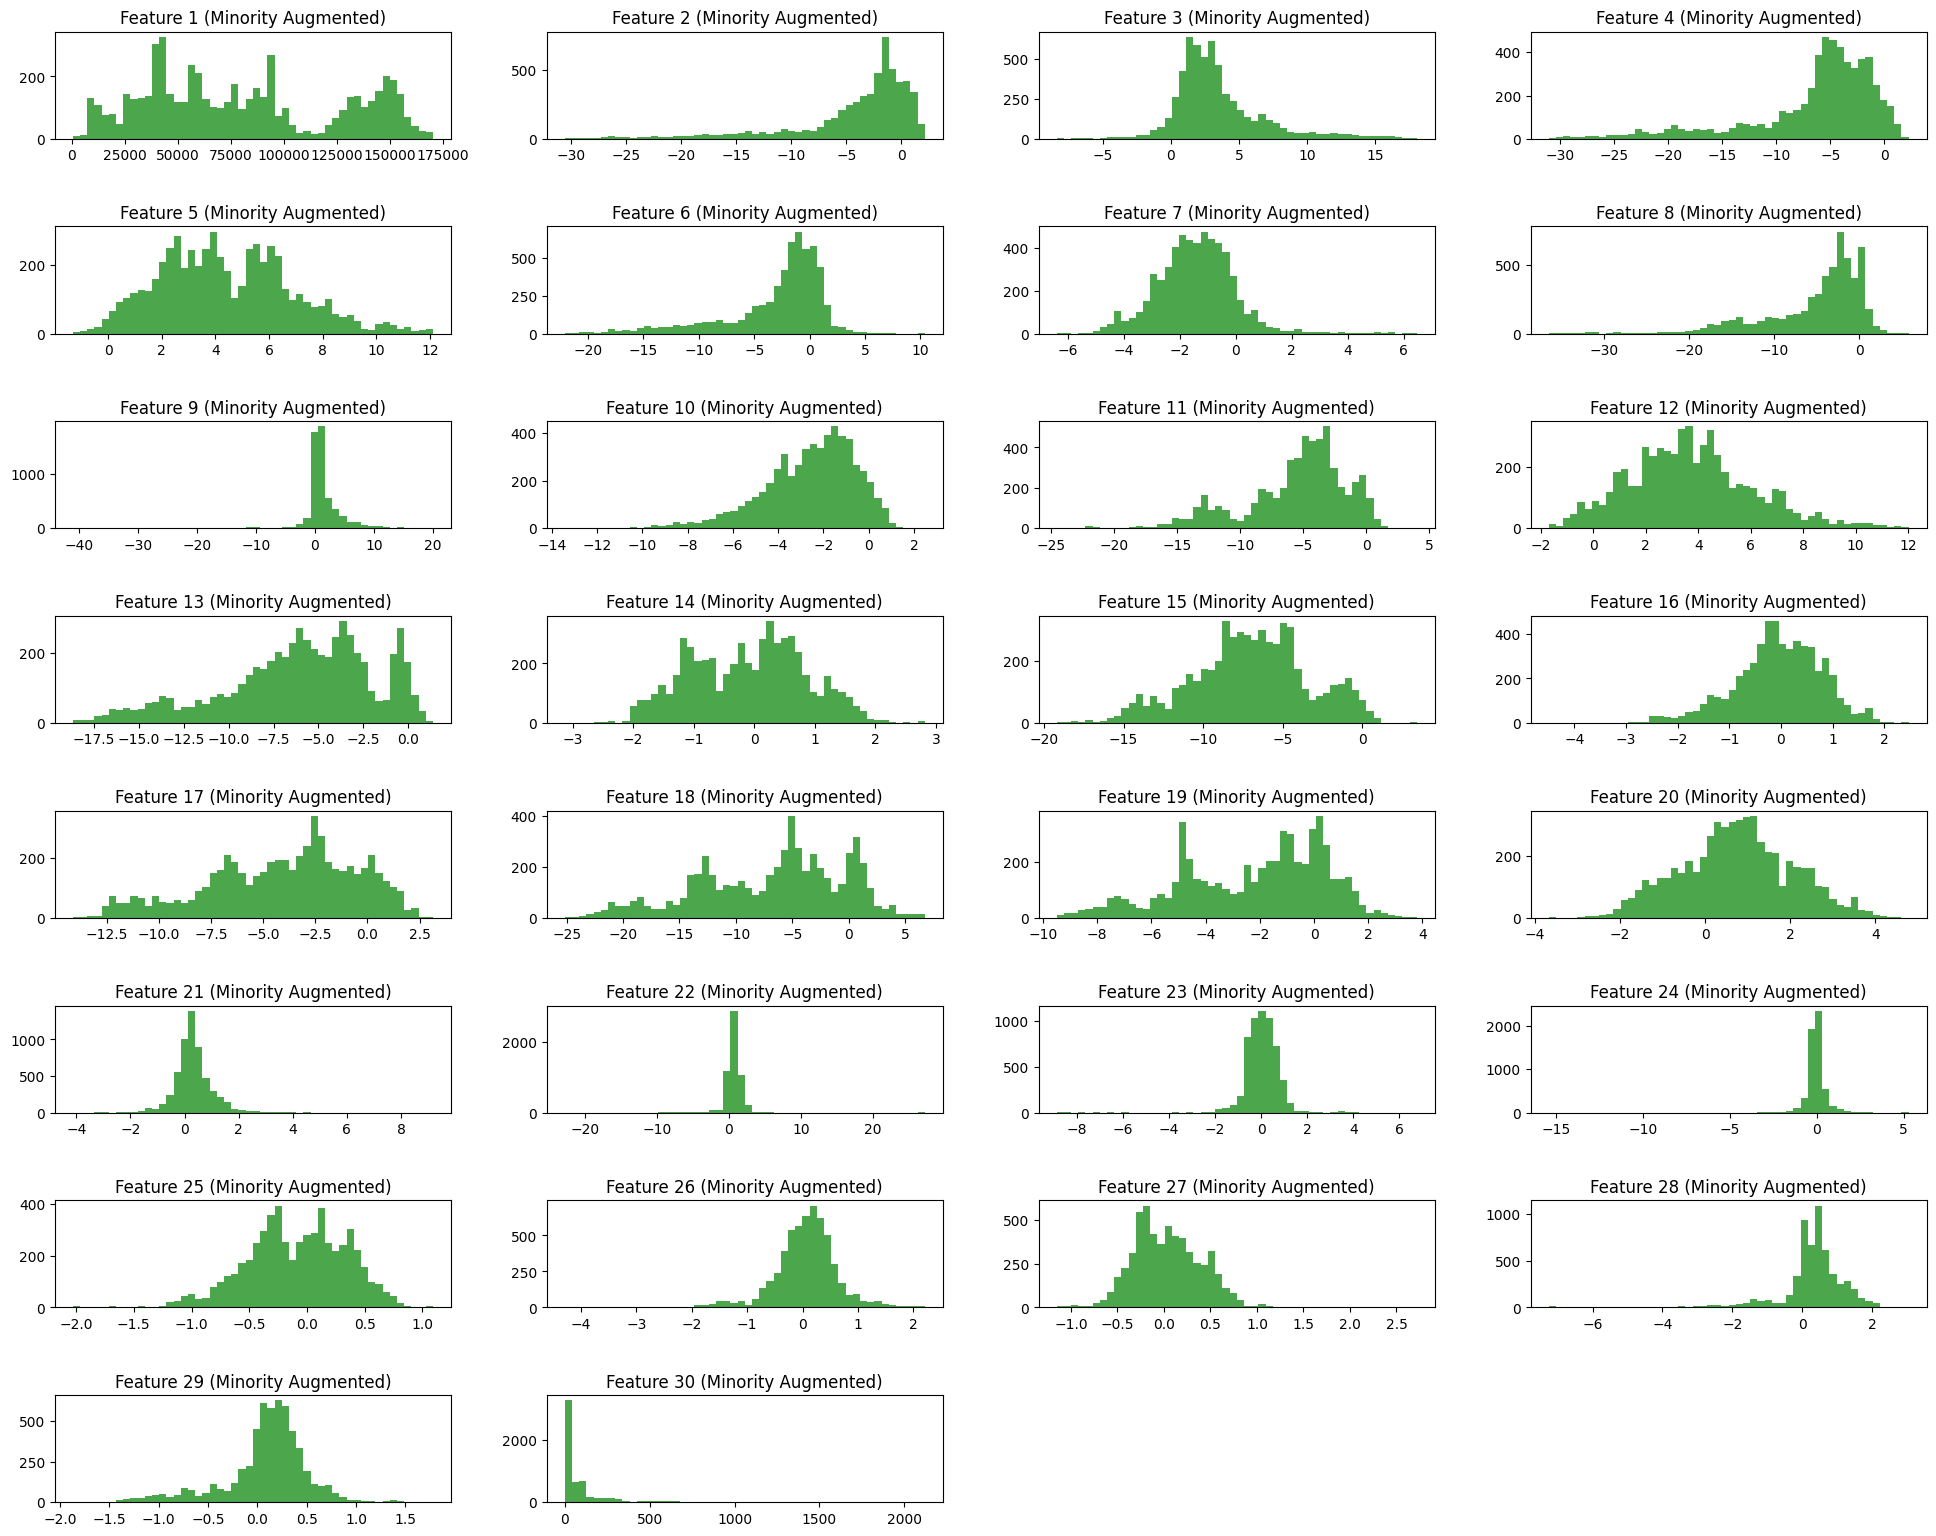

Class distribution after augmentation: {0.0: 284315, 1.0: 6188}

Training Random Forest...
Random Forest - Recall (original): 0.8162, Recall (generated): 0.8869
Random Forest - F1 (original): 0.8638, F1 (generated): 0.9318
Number of fake samples generated: 5696


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier

# Step 1: Load the CSV file
file_path = '/kaggle/working/Practice/creditcard.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Plot the original minority class data (first two features for visualization)
plt.figure(figsize=(20, 16))
num_features = X.shape[1]
cols = 4  # 4 plots per row
rows = (num_features + cols - 1) // cols  # Calculate rows

# Separate the minority class for original data
X_minority = X[y == 1]

# Plot the original minority class data
for i in range(num_features):
    plt.subplot(rows, cols, i + 1)
    plt.hist(X_minority[:, i], bins=50, alpha=0.7, color='blue')
    plt.title(f'Feature {i+1} (Minority Original)', fontsize=12)
    plt.tight_layout(pad=3.0)

plt.show()

# Step 4: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X) // 50)

# Add generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)

# Step 5: Plot the augmented minority class data
plt.figure(figsize=(20, 16))

# Plot the augmented minority class data
for i in range(num_features):
    plt.subplot(rows, cols, i + 1)
    plt.hist(X_minority_fake[:, i], bins=50, alpha=0.7, color='green')
    plt.title(f'Feature {i+1} (Minority Augmented)', fontsize=12)
    plt.tight_layout(pad=3.0)

plt.show()

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 6: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 7: Define Random Forest Classifier
classifier = RandomForestClassifier()

# Step 8: Train and evaluate the classifier using original and balanced data
print(f"\nTraining Random Forest...")

# Train on original data
classifier.fit(X_train_orig, y_train_orig)
y_pred_orig = classifier.predict(X_test_orig)

# Train on balanced data
classifier.fit(X_train_bal, y_train_bal)
y_pred_bal = classifier.predict(X_test_bal)

# Calculate recall and F1 scores
recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_bal, y_pred_bal)
f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_bal, y_pred_bal)

# Print the performance metrics
print(f"Random Forest - Recall (original): {recall_orig:.4f}, Recall (generated): {recall_bal:.4f}")
print(f"Random Forest - F1 (original): {f1_orig:.4f}, F1 (generated): {f1_bal:.4f}")

# Step 9: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")


# #Overlapping distribution using RandomForest

Class distribution before augmentation: {0: 284315, 1: 492}


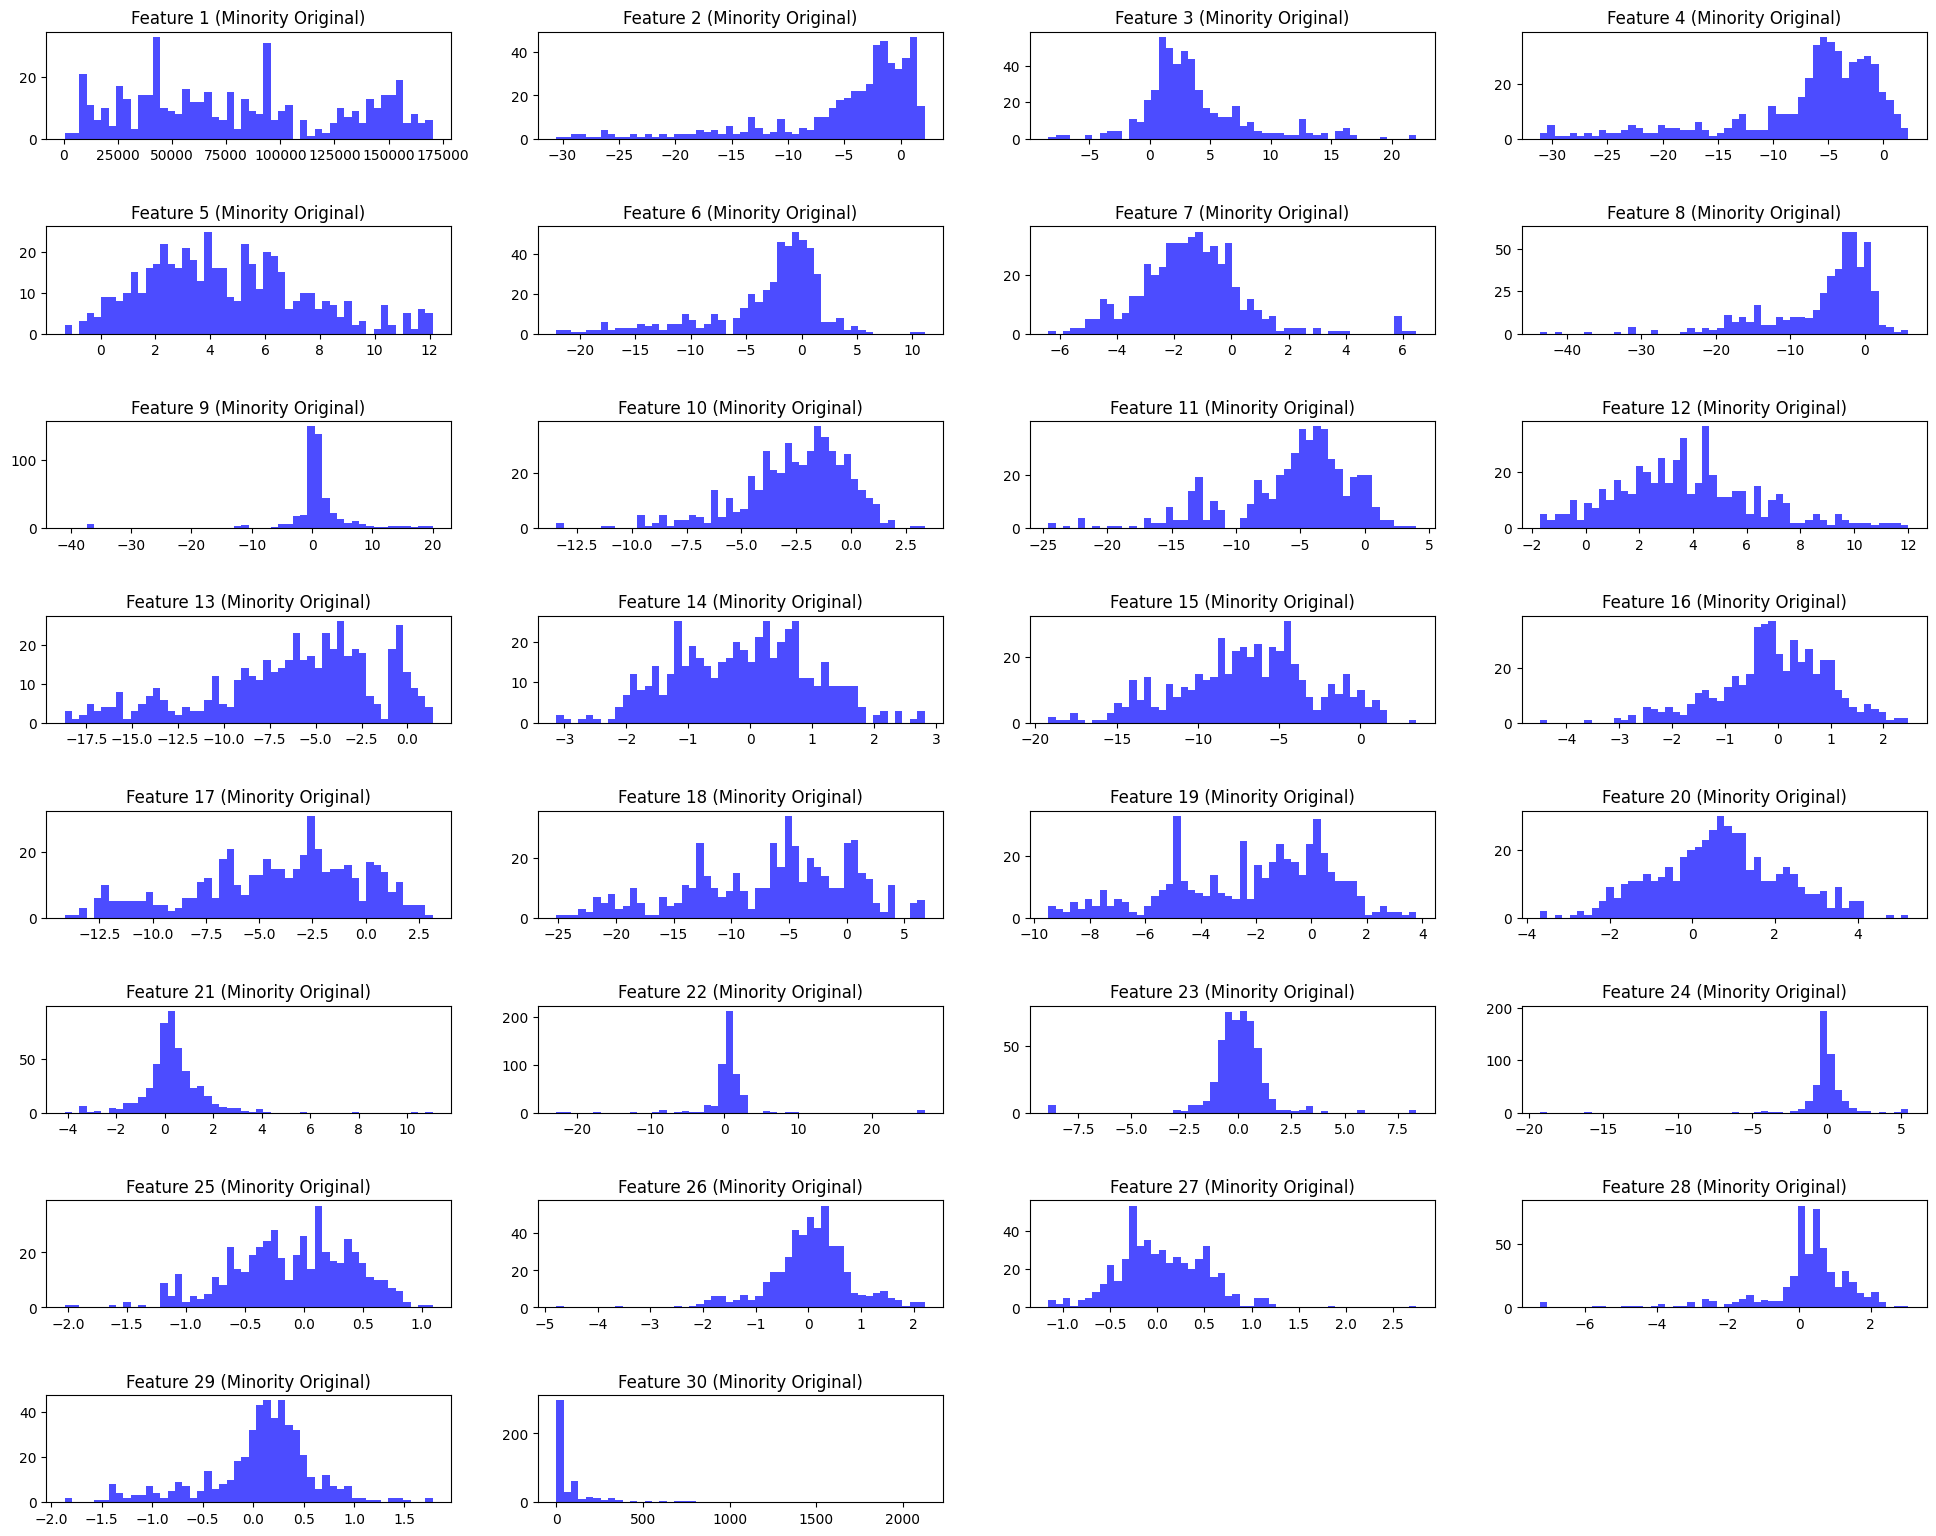

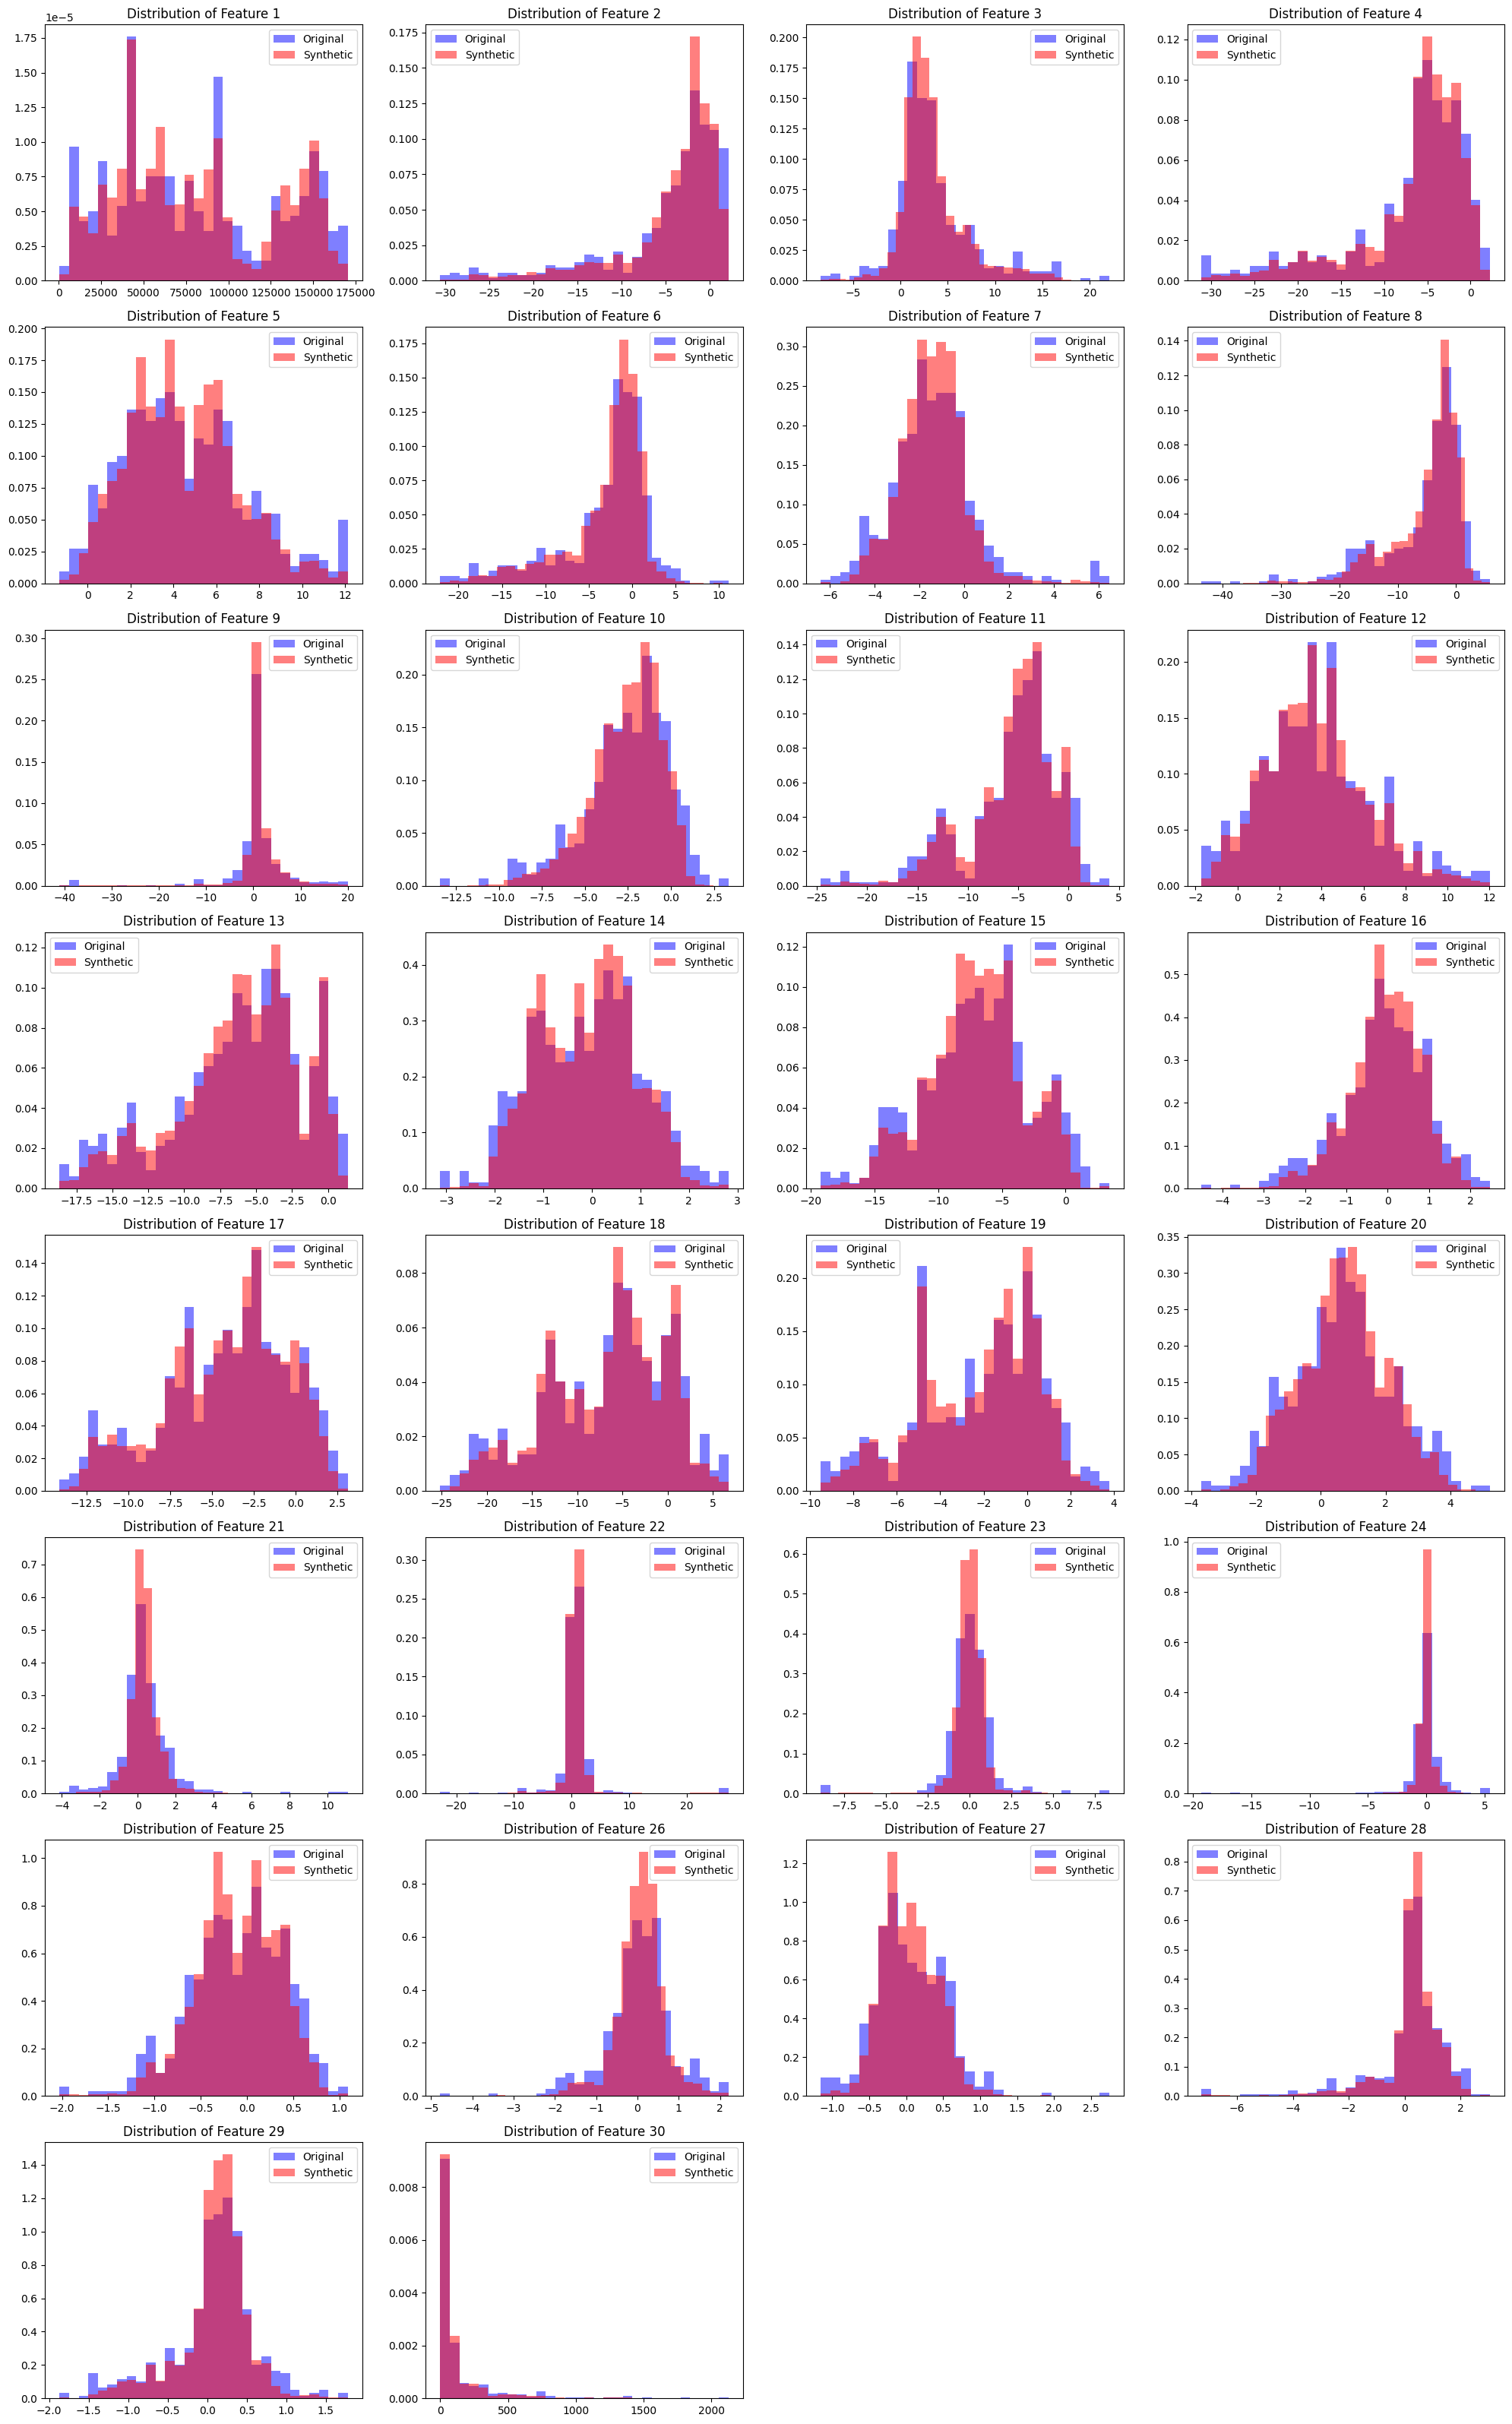

Class distribution after augmentation: {0.0: 284315, 1.0: 6188}

Training Random Forest...
Random Forest - Recall (original): 0.8162, Recall (generated): 0.8869
Random Forest - F1 (original): 0.8638, F1 (generated): 0.9318
Number of fake samples generated: 5696


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier

# Step 1: Load the CSV file
file_path = '/kaggle/working/Practice/creditcard.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Plot the original minority class data (first two features for visualization)
plt.figure(figsize=(20, 16))
num_features = X.shape[1]
cols = 4  # 4 plots per row
rows = (num_features + cols - 1) // cols  # Calculate rows

# Separate the minority class for original data
X_minority = X[y == 1]

# Plot the original minority class data
for i in range(num_features):
    plt.subplot(rows, cols, i + 1)
    plt.hist(X_minority[:, i], bins=50, alpha=0.7, color='blue')
    plt.title(f'Feature {i+1} (Minority Original)', fontsize=12)
    plt.tight_layout(pad=3.0)

plt.show()

# Step 4: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X) // 50)

# Add generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)

# Step 5: Define a function to plot feature distributions (original vs. synthetic data)
def plot_feature_distributions(original_data, synthetic_data, num_cols=4):
    num_features = original_data.shape[1]
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows

    plt.figure(figsize=(20, num_rows * 4))  # Adjust figure size dynamically

    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Plot original data (blue)
        plt.hist(original_data[:, i], bins=30, alpha=0.5, label='Original', color='blue', density=True)
        
        # Plot synthetic data (red)
        plt.hist(synthetic_data[:, i], bins=30, alpha=0.5, label='Synthetic', color='red', density=True)
        
        plt.title(f'Distribution of Feature {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the distribution of all features (before and after augmentation for the minority class)
plot_feature_distributions(X_minority, X_minority_fake)

# Step 6: Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 7: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 8: Define Random Forest Classifier
classifier = RandomForestClassifier()

# Step 9: Train and evaluate the classifier using original and balanced data
print(f"\nTraining Random Forest...")

# Train on original data
classifier.fit(X_train_orig, y_train_orig)
y_pred_orig = classifier.predict(X_test_orig)

# Train on balanced data
classifier.fit(X_train_bal, y_train_bal)
y_pred_bal = classifier.predict(X_test_bal)

# Calculate recall and F1 scores
recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_bal, y_pred_bal)
f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_bal, y_pred_bal)

# Print the performance metrics
print(f"Random Forest - Recall (original): {recall_orig:.4f}, Recall (generated): {recall_bal:.4f}")
print(f"Random Forest - F1 (original): {f1_orig:.4f}, F1 (generated): {f1_bal:.4f}")

# Step 10: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")


# #Distribution using GradientBoosting

Class distribution before augmentation: {0: 284315, 1: 492}


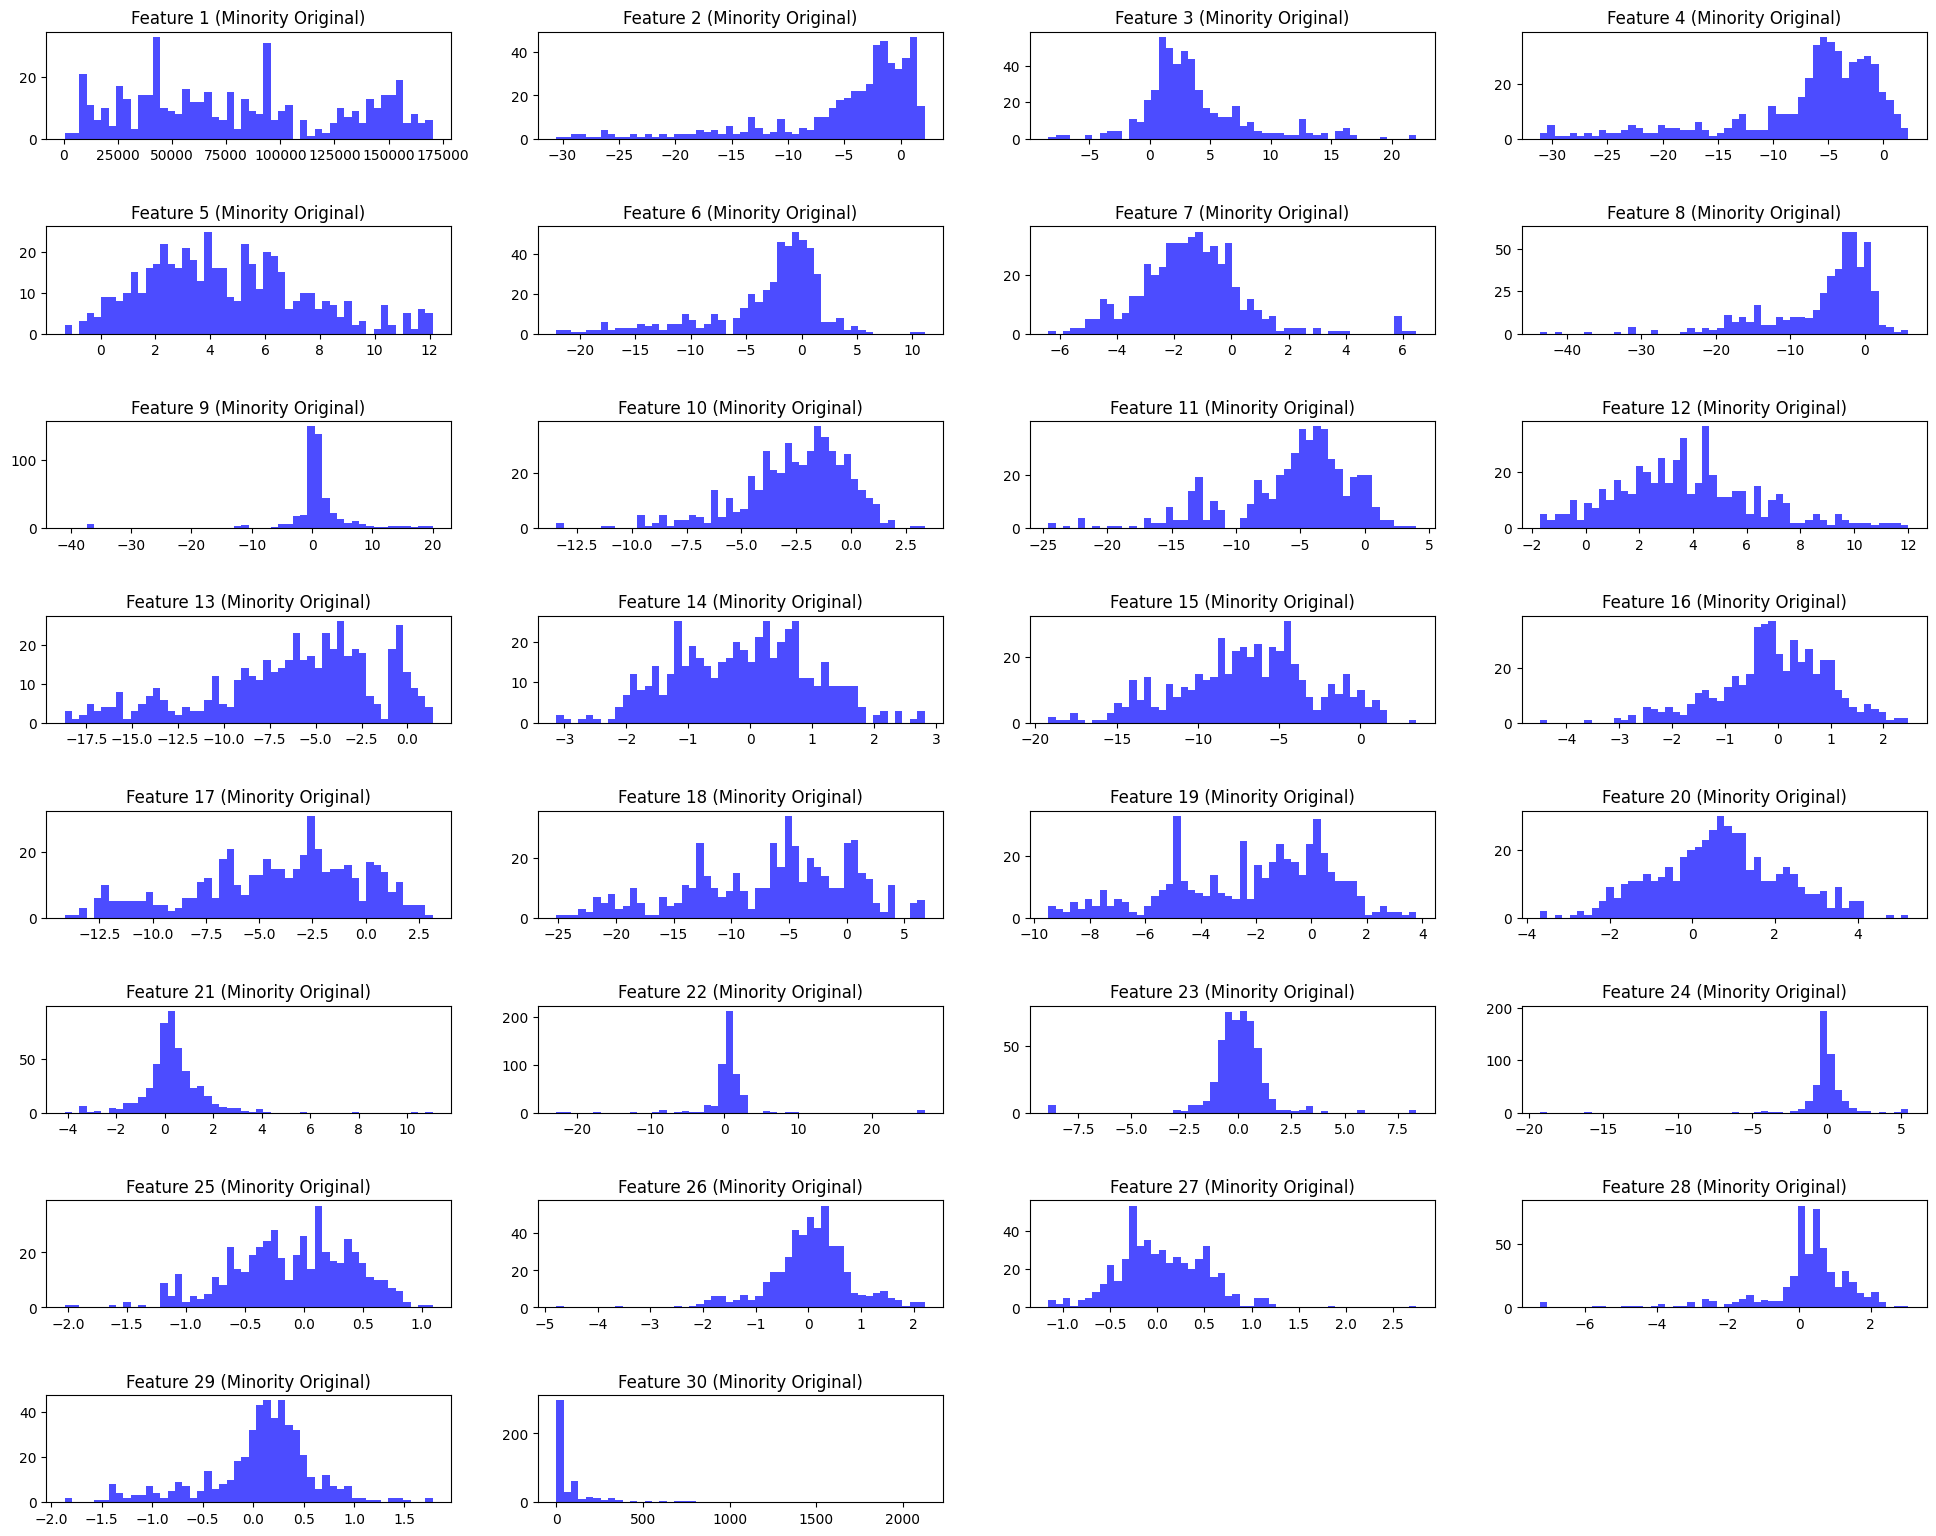

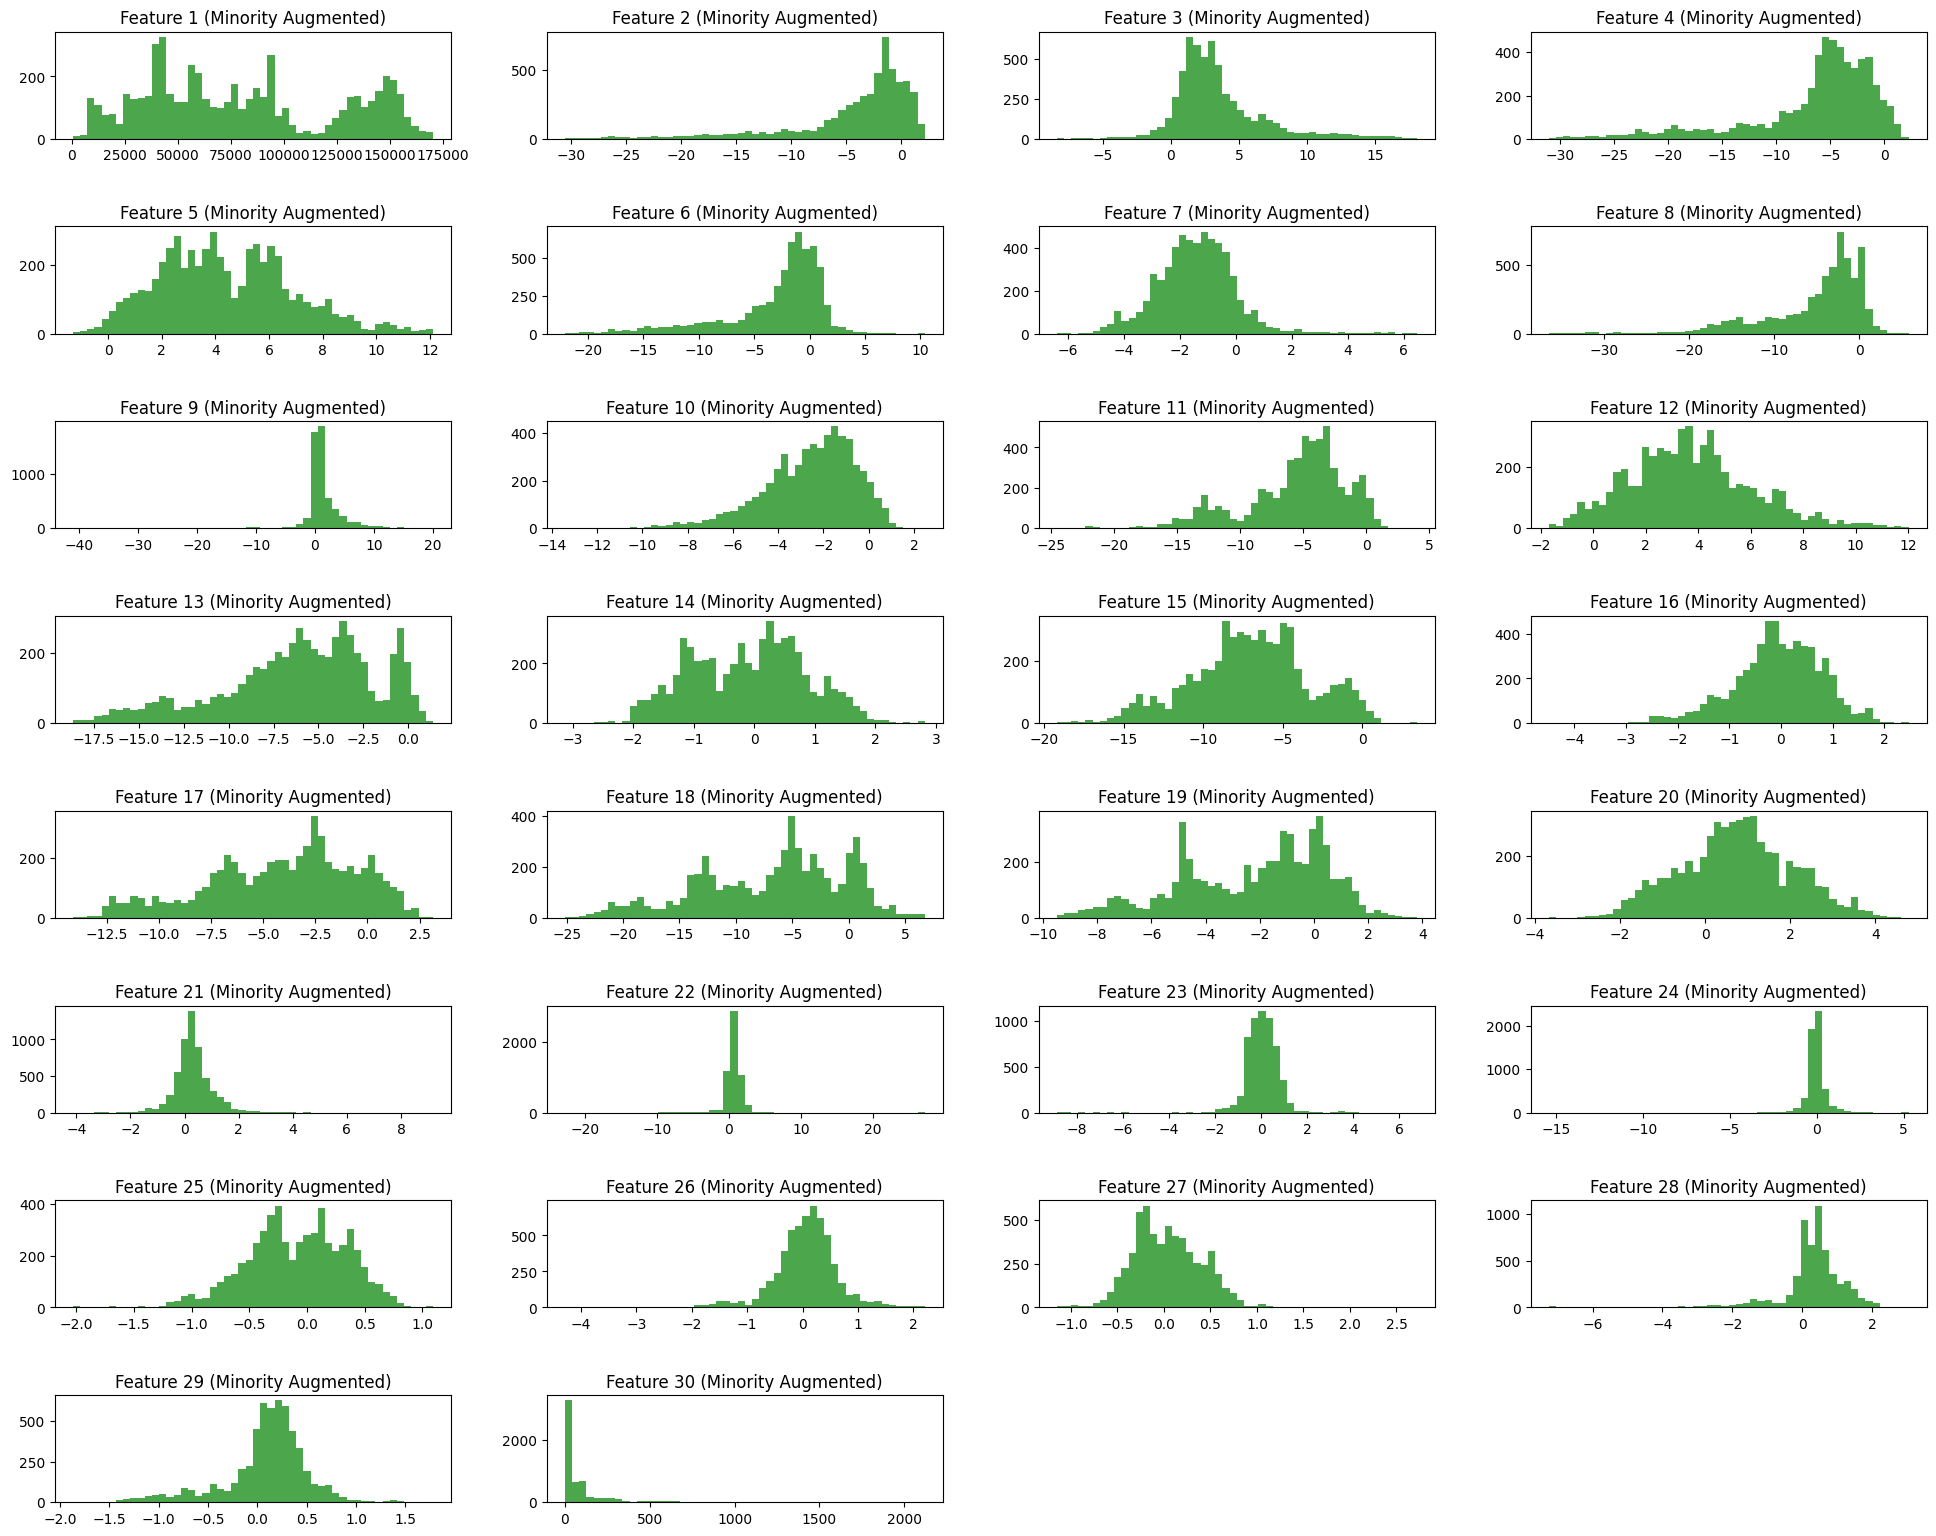

Class distribution after augmentation: {0.0: 284315, 1.0: 6188}

Training Gradient Boosting...
Gradient Boosting - Recall (original): 0.1250, Recall (generated): 0.8819
Gradient Boosting - F1 (original): 0.2194, F1 (generated): 0.9214
Number of fake samples generated: 5696


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import GradientBoostingClassifier

# Step 1: Load the CSV file
file_path = '/kaggle/working/Practice/creditcard.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Plot the original minority class data (first two features for visualization)
plt.figure(figsize=(20, 16))
num_features = X.shape[1]
cols = 4  # 4 plots per row
rows = (num_features + cols - 1) // cols  # Calculate rows

# Separate the minority class for original data
X_minority = X[y == 1]

# Plot the original minority class data
for i in range(num_features):
    plt.subplot(rows, cols, i + 1)
    plt.hist(X_minority[:, i], bins=50, alpha=0.7, color='blue')
    plt.title(f'Feature {i+1} (Minority Original)', fontsize=12)
    plt.tight_layout(pad=3.0)

plt.show()

# Step 4: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X) // 50)

# Add generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)

# Step 5: Plot the augmented minority class data
plt.figure(figsize=(20, 16))

# Plot the augmented minority class data
for i in range(num_features):
    plt.subplot(rows, cols, i + 1)
    plt.hist(X_minority_fake[:, i], bins=50, alpha=0.7, color='green')
    plt.title(f'Feature {i+1} (Minority Augmented)', fontsize=12)
    plt.tight_layout(pad=3.0)

plt.show()

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 6: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 7: Define Gradient Boosting Classifier
classifier = GradientBoostingClassifier()

# Step 8: Train and evaluate the classifier using original and balanced data
print(f"\nTraining Gradient Boosting...")

# Train on original data
classifier.fit(X_train_orig, y_train_orig)
y_pred_orig = classifier.predict(X_test_orig)

# Train on balanced data
classifier.fit(X_train_bal, y_train_bal)
y_pred_bal = classifier.predict(X_test_bal)

# Calculate recall and F1 scores
recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_bal, y_pred_bal)
f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_bal, y_pred_bal)

# Print the performance metrics
print(f"Gradient Boosting - Recall (original): {recall_orig:.4f}, Recall (generated): {recall_bal:.4f}")
print(f"Gradient Boosting - F1 (original): {f1_orig:.4f}, F1 (generated): {f1_bal:.4f}")

# Step 9: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")


# #Distribution using XGBoost

Class distribution before augmentation: {0: 284315, 1: 492}


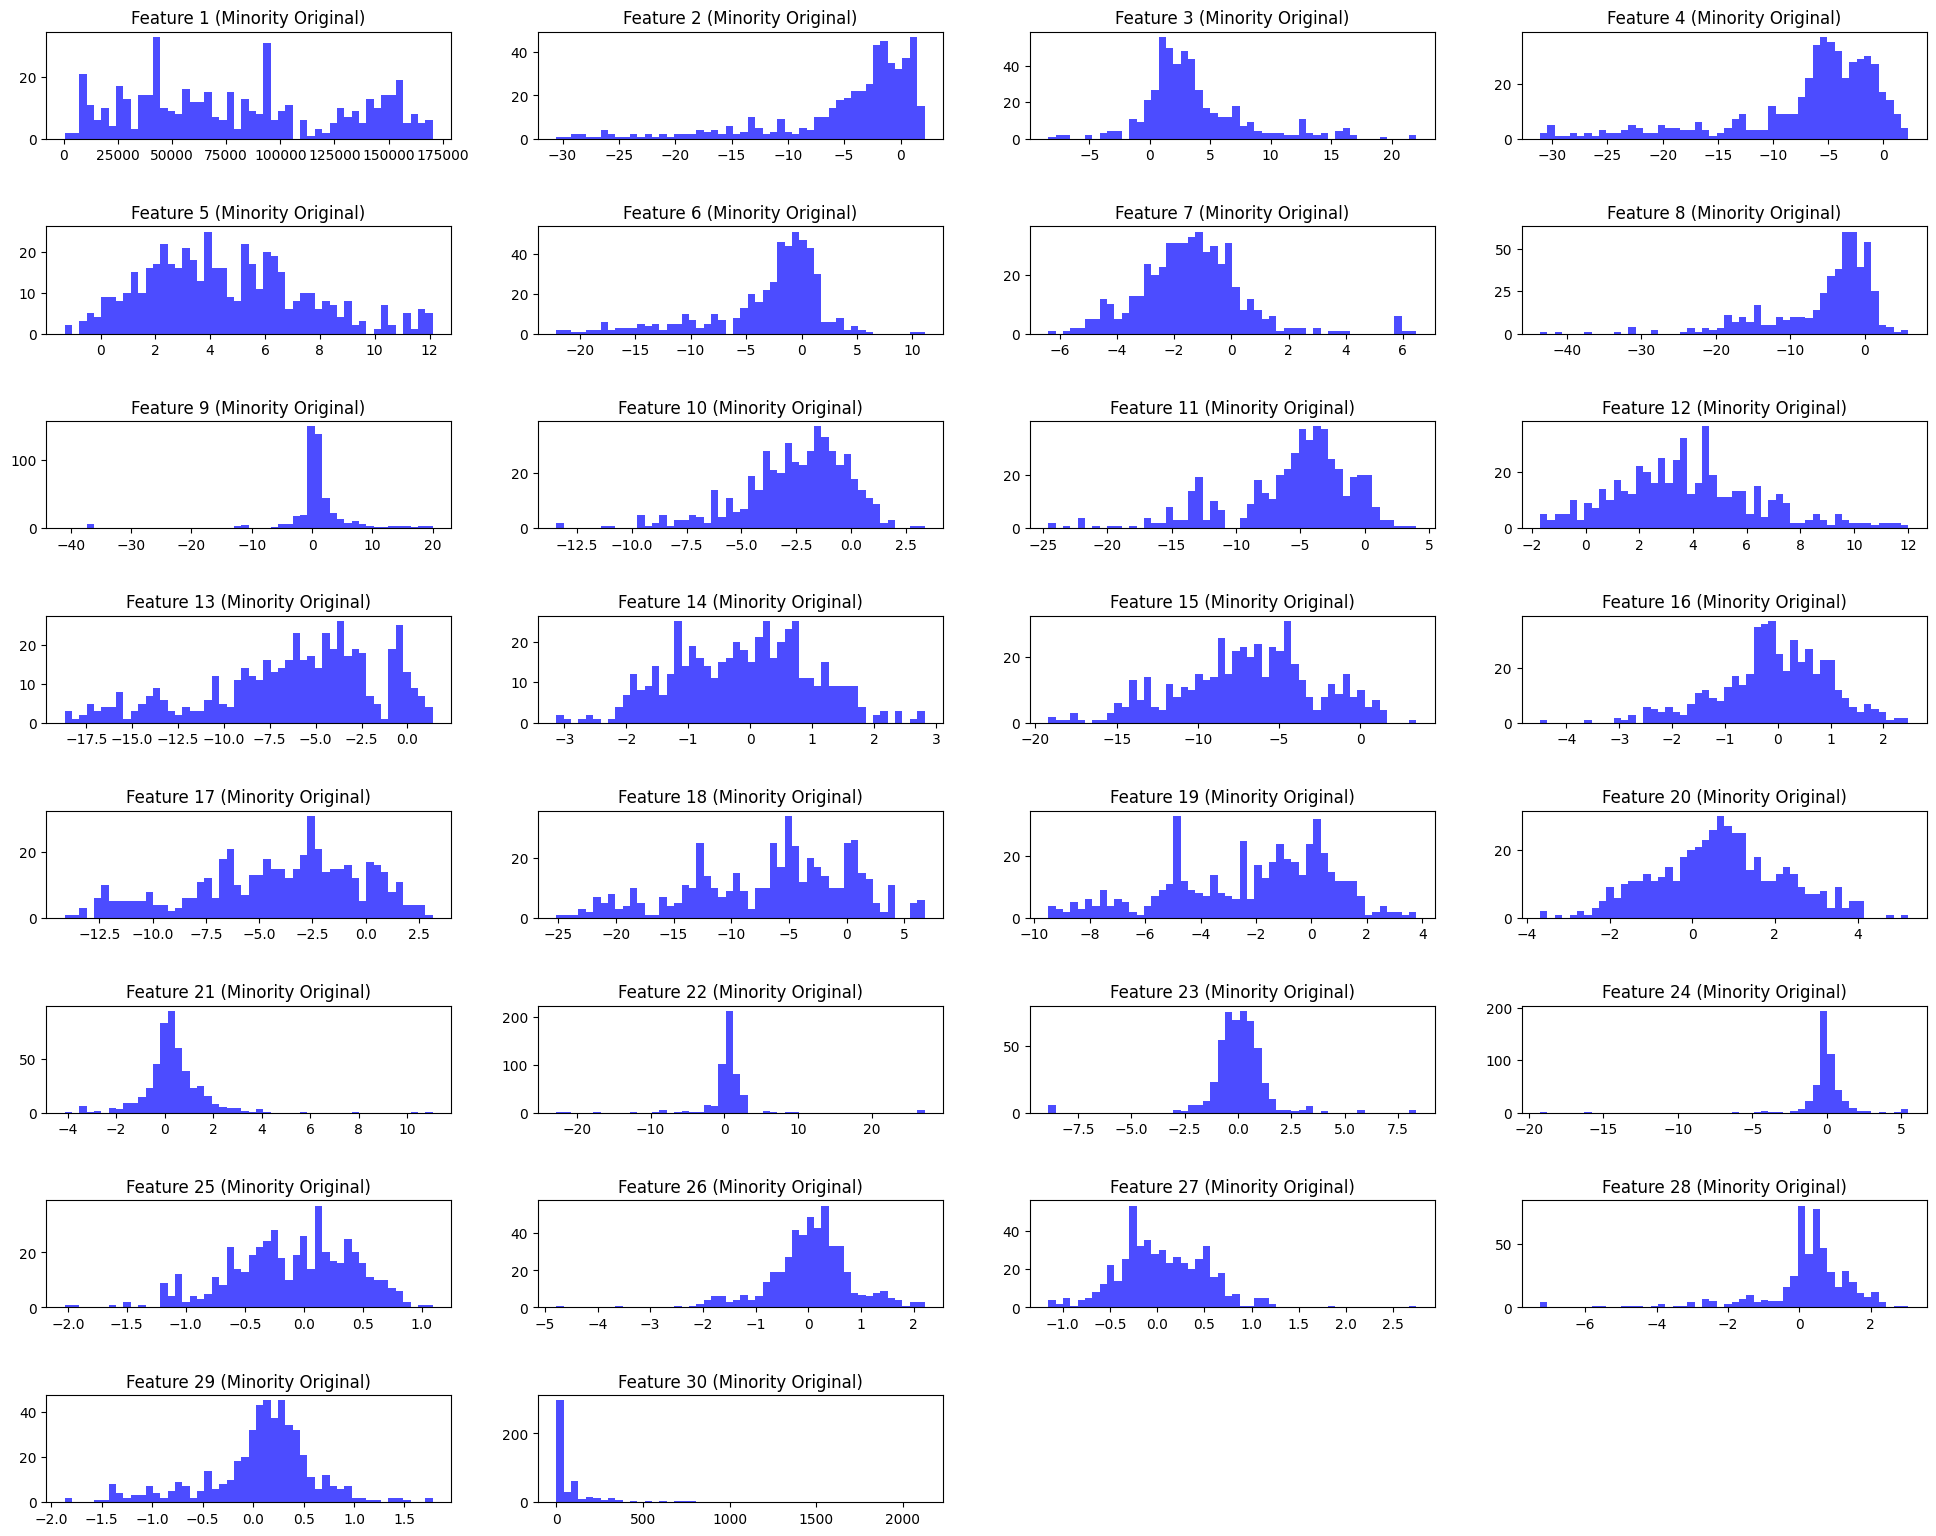

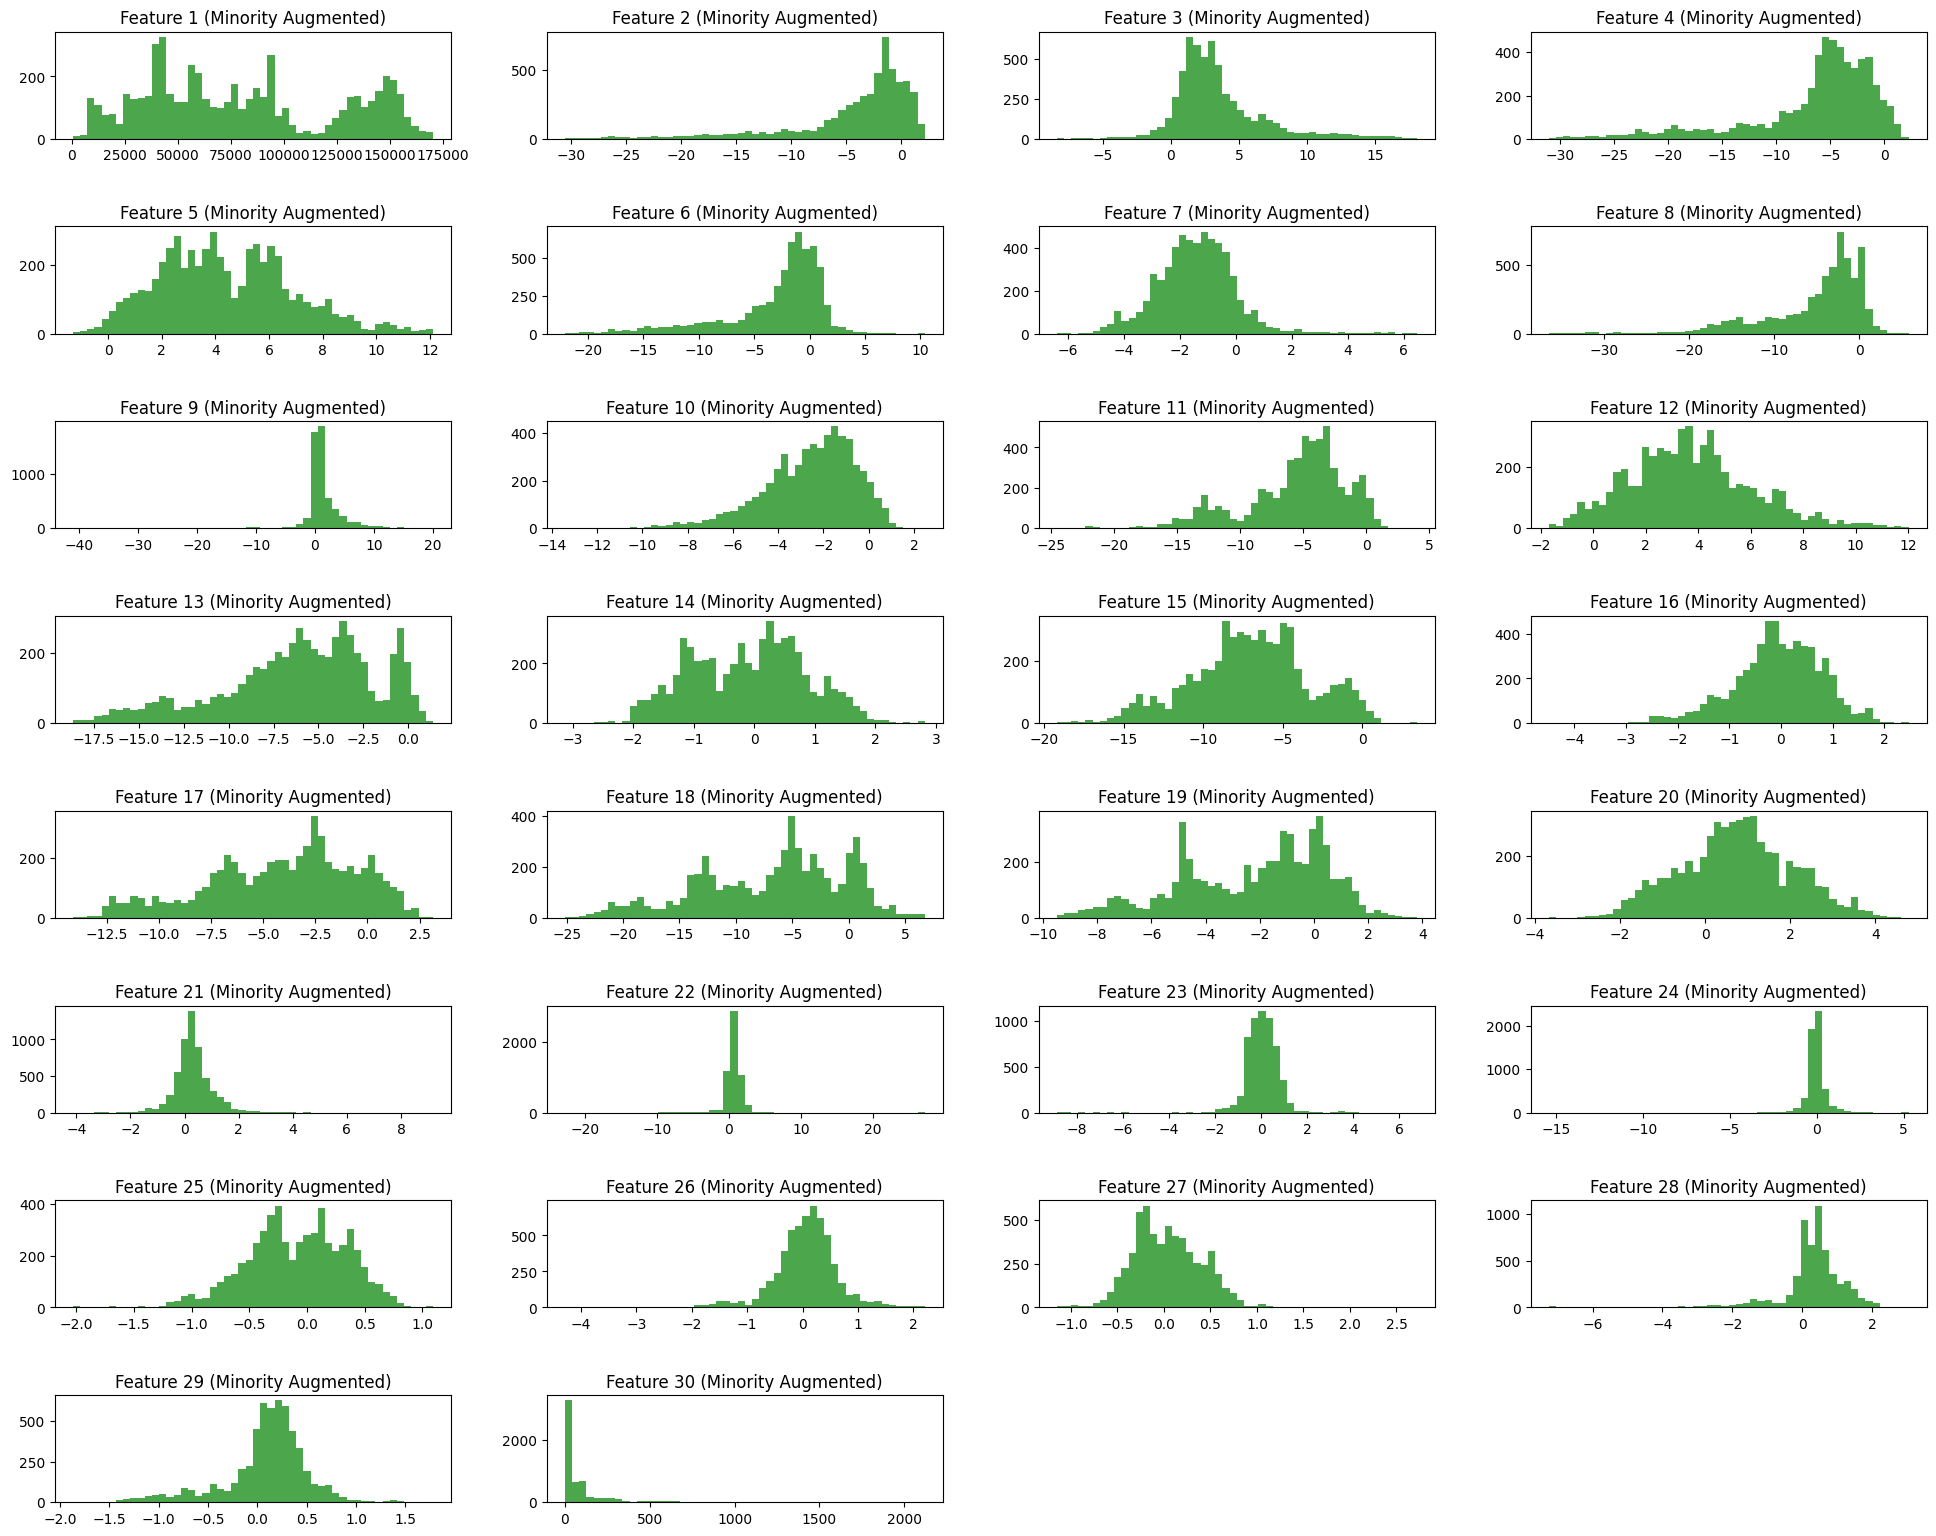

Class distribution after augmentation: {0.0: 284315, 1.0: 6188}

Training XGBoost...
XGBoost - Recall (original): 0.8162, Recall (generated): 0.9493
XGBoost - F1 (original): 0.8706, F1 (generated): 0.9676
Number of fake samples generated: 5696


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
import xgboost as xgb

# Step 1: Load the CSV file
file_path = '/kaggle/working/Practice/creditcard.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Plot the original minority class data (first two features for visualization)
plt.figure(figsize=(20, 16))
num_features = X.shape[1]
cols = 4  # 4 plots per row
rows = (num_features + cols - 1) // cols  # Calculate rows

# Separate the minority class for original data
X_minority = X[y == 1]

# Plot the original minority class data
for i in range(num_features):
    plt.subplot(rows, cols, i + 1)
    plt.hist(X_minority[:, i], bins=50, alpha=0.7, color='blue')
    plt.title(f'Feature {i+1} (Minority Original)', fontsize=12)
    plt.tight_layout(pad=3.0)

plt.show()

# Step 4: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X) // 50)

# Add generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)

# Step 5: Plot the augmented minority class data
plt.figure(figsize=(20, 16))

# Plot the augmented minority class data
for i in range(num_features):
    plt.subplot(rows, cols, i + 1)
    plt.hist(X_minority_fake[:, i], bins=50, alpha=0.7, color='green')
    plt.title(f'Feature {i+1} (Minority Augmented)', fontsize=12)
    plt.tight_layout(pad=3.0)

plt.show()

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 6: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 7: Define XGBoost Classifier
classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Step 8: Train and evaluate the classifier using original and balanced data
print(f"\nTraining XGBoost...")

# Train on original data
classifier.fit(X_train_orig, y_train_orig)
y_pred_orig = classifier.predict(X_test_orig)

# Train on balanced data
classifier.fit(X_train_bal, y_train_bal)
y_pred_bal = classifier.predict(X_test_bal)

# Calculate recall and F1 scores
recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_bal, y_pred_bal)
f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_bal, y_pred_bal)

# Print the performance metrics
print(f"XGBoost - Recall (original): {recall_orig:.4f}, Recall (generated): {recall_bal:.4f}")
print(f"XGBoost - F1 (original): {f1_orig:.4f}, F1 (generated): {f1_bal:.4f}")

# Step 9: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")


# #SupportVectorClassifier

Class distribution before augmentation: {0: 284315, 1: 492}


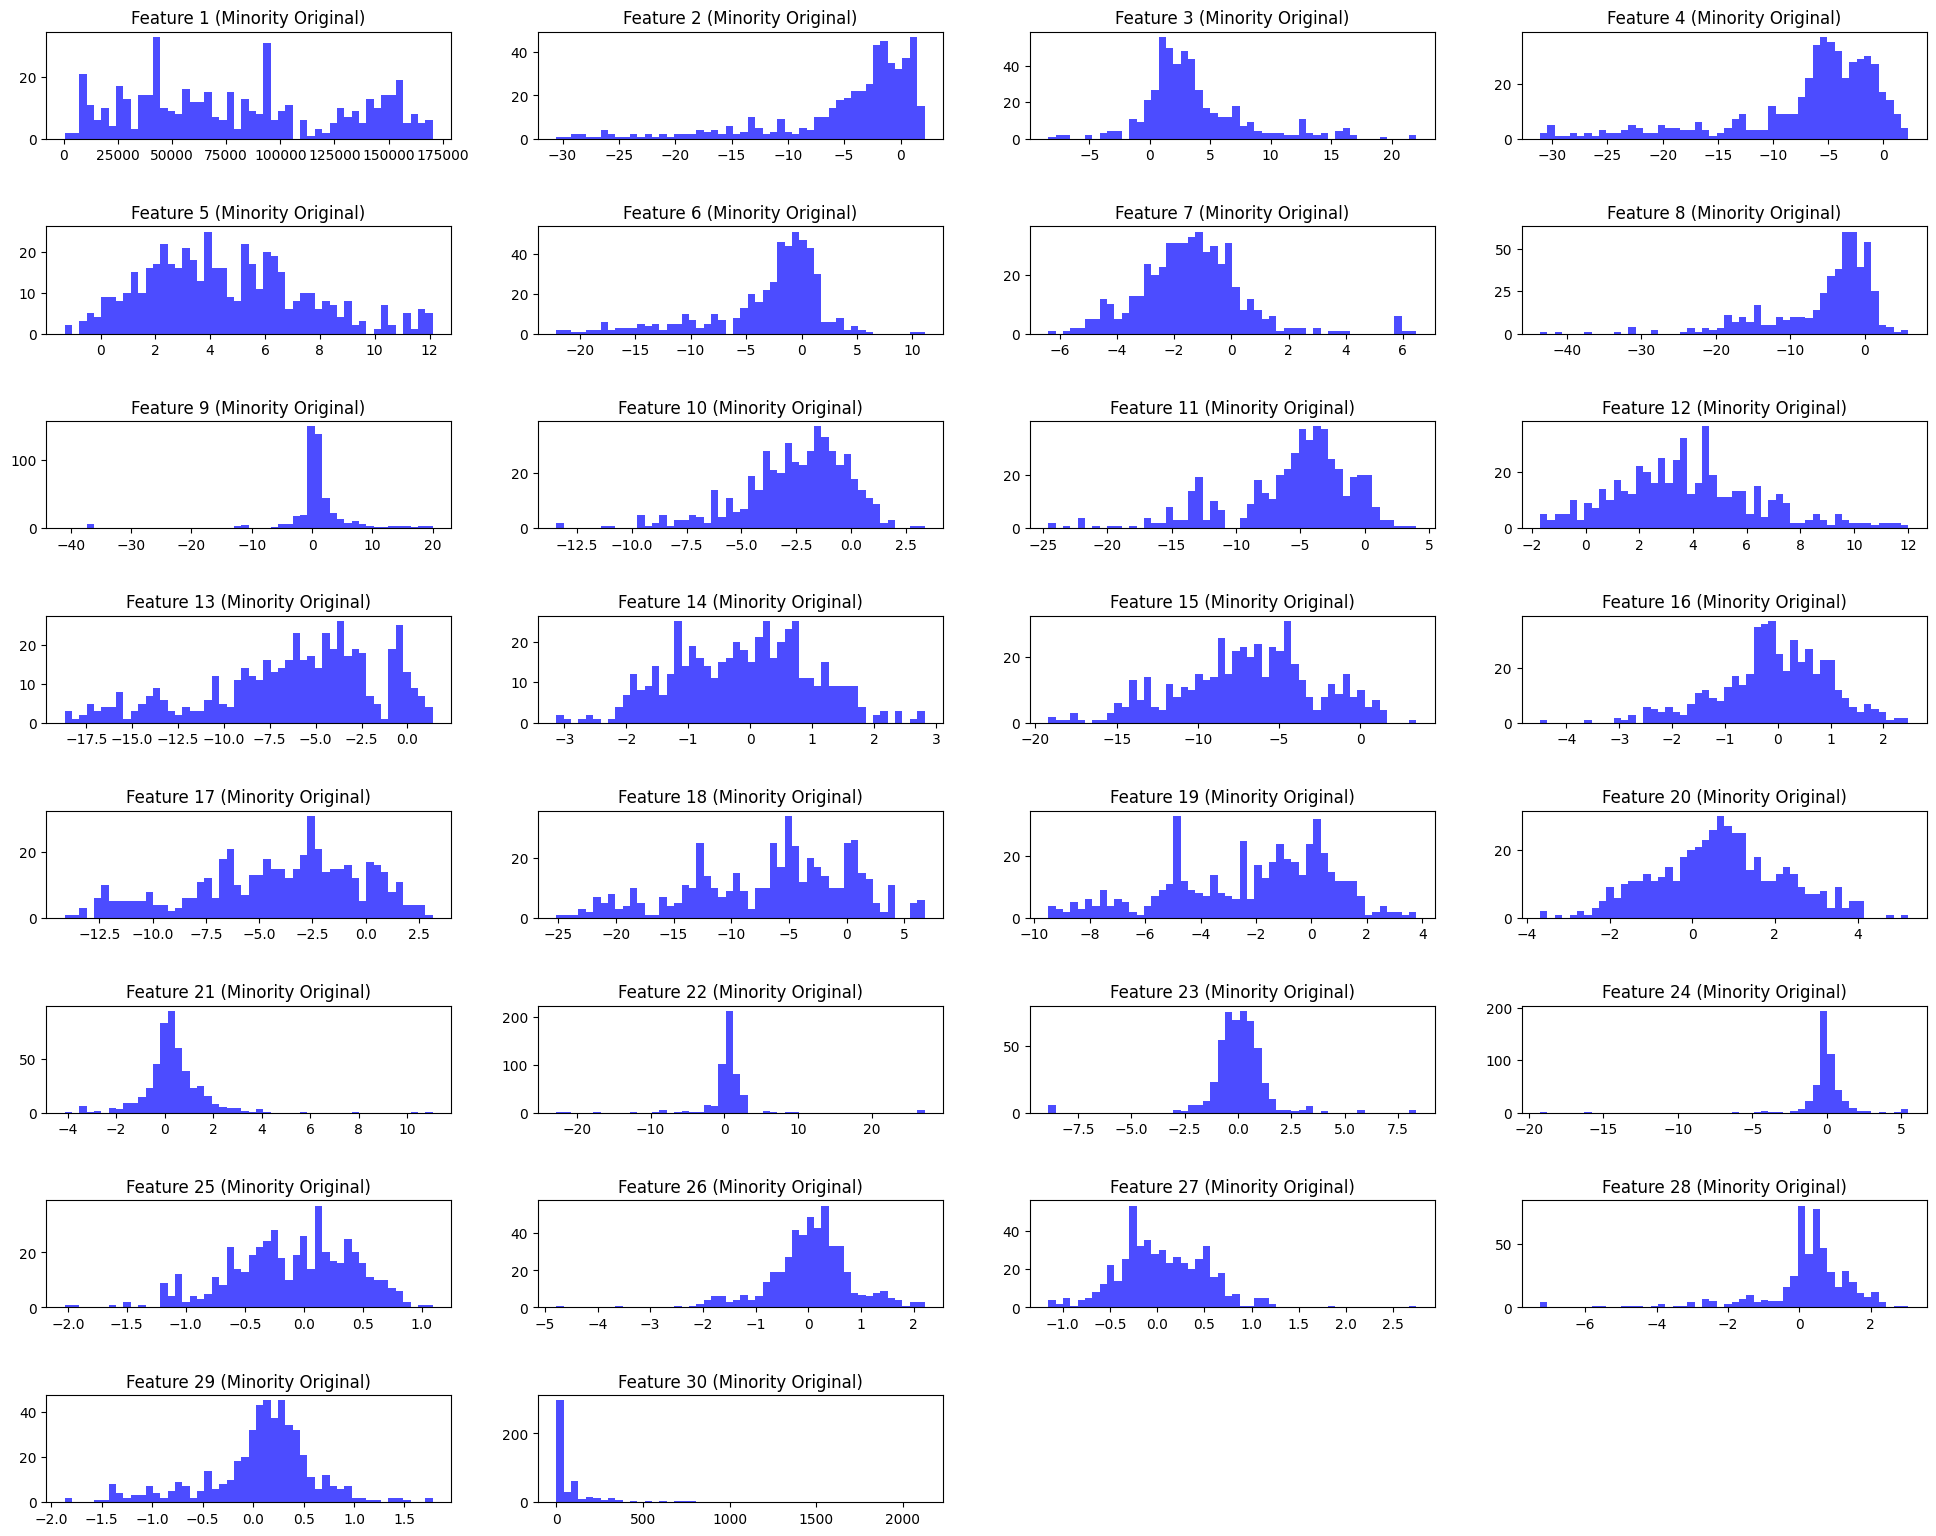

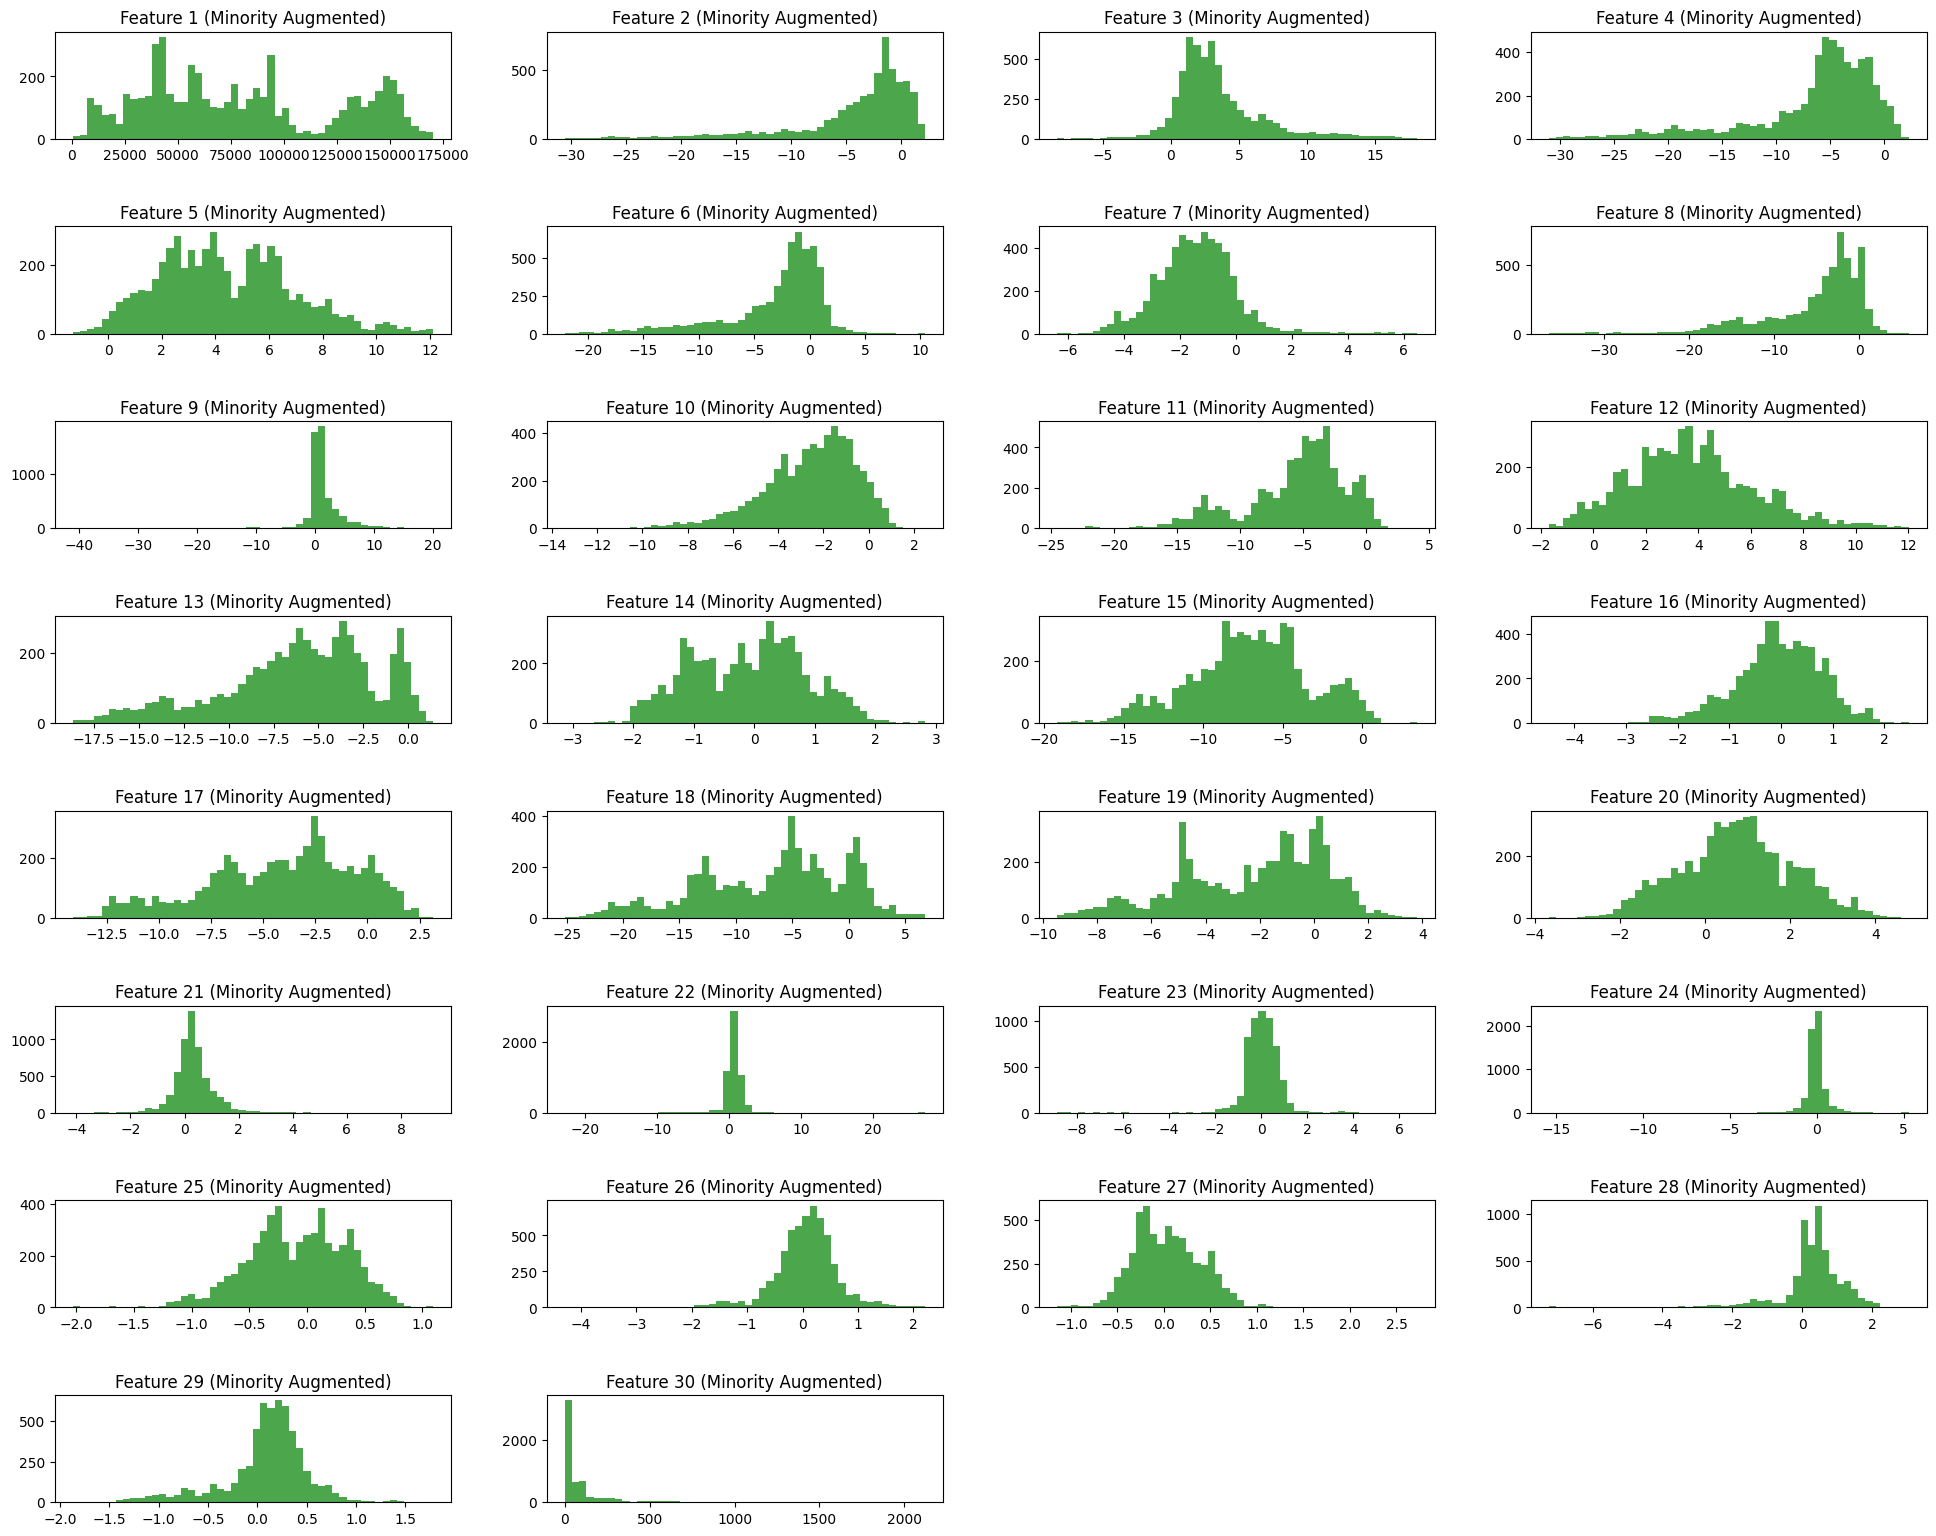

Class distribution after augmentation: {0.0: 284315, 1.0: 6188}

Training Support Vector Classifier (SVC)...


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.svm import SVC

# Step 1: Load the CSV file
file_path = '/kaggle/working/Practice/creditcard.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Plot the original minority class data (first two features for visualization)
plt.figure(figsize=(20, 16))
num_features = X.shape[1]
cols = 4  # 4 plots per row
rows = (num_features + cols - 1) // cols  # Calculate rows

# Separate the minority class for original data
X_minority = X[y == 1]

# Plot the original minority class data
for i in range(num_features):
    plt.subplot(rows, cols, i + 1)
    plt.hist(X_minority[:, i], bins=50, alpha=0.7, color='blue')
    plt.title(f'Feature {i+1} (Minority Original)', fontsize=12)
    plt.tight_layout(pad=3.0)

plt.show()

# Step 4: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X) // 50)

# Add generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)

# Step 5: Plot the augmented minority class data
plt.figure(figsize=(20, 16))

# Plot the augmented minority class data
for i in range(num_features):
    plt.subplot(rows, cols, i + 1)
    plt.hist(X_minority_fake[:, i], bins=50, alpha=0.7, color='green')
    plt.title(f'Feature {i+1} (Minority Augmented)', fontsize=12)
    plt.tight_layout(pad=3.0)

plt.show()

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 6: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 7: Define Support Vector Classifier (SVC) with class_weight='balanced'
classifier = SVC(class_weight='balanced')

# Step 8: Train and evaluate the classifier using original and balanced data
print(f"\nTraining Support Vector Classifier (SVC)...")

# Train on original data
classifier.fit(X_train_orig, y_train_orig)
y_pred_orig = classifier.predict(X_test_orig)

# Train on balanced data
classifier.fit(X_train_bal, y_train_bal)
y_pred_bal = classifier.predict(X_test_bal)

# Calculate recall and F1 scores
recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_bal, y_pred_bal)
f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_bal, y_pred_bal)

# Print the performance metrics
print(f"SVC - Recall (original): {recall_orig:.4f}, Recall (generated): {recall_bal:.4f}")
print(f"SVC - F1 (original): {f1_orig:.4f}, F1 (generated): {f1_bal:.4f}")

# Step 9: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")


# #Dimensionality Reduction (PCA)

Class distribution before augmentation: {0: 284315, 1: 492}


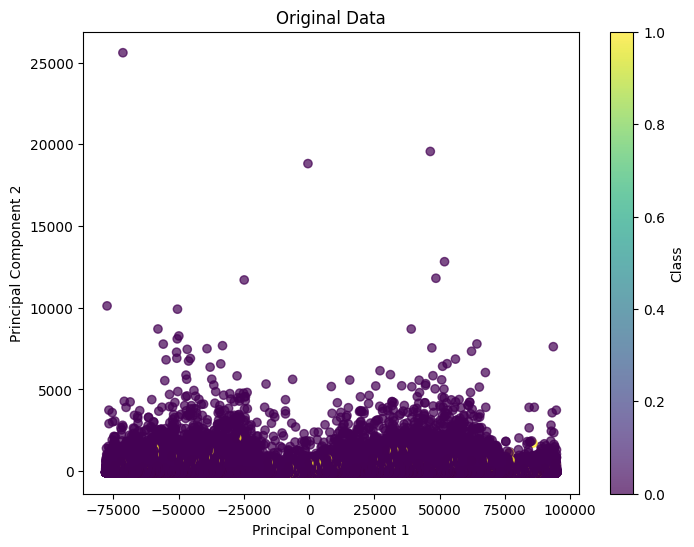

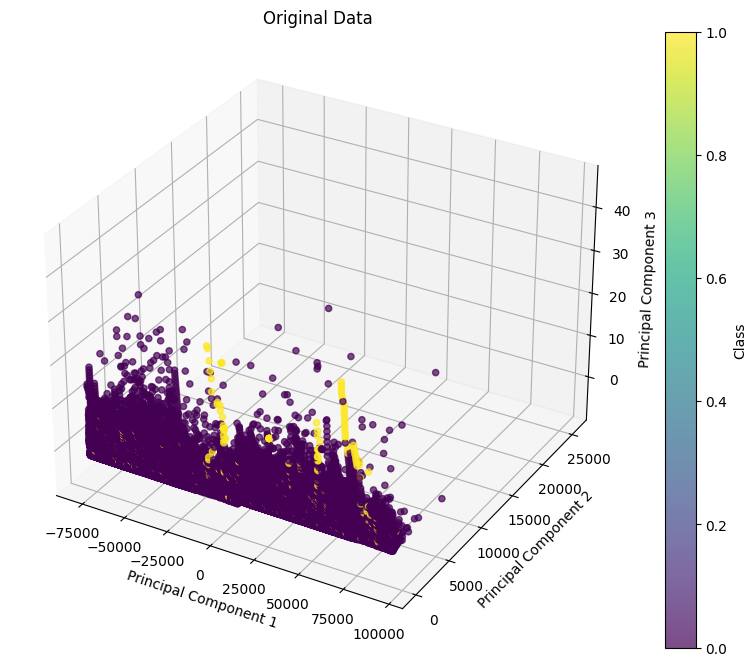

Class distribution after augmentation: {0.0: 284315, 1.0: 6188}


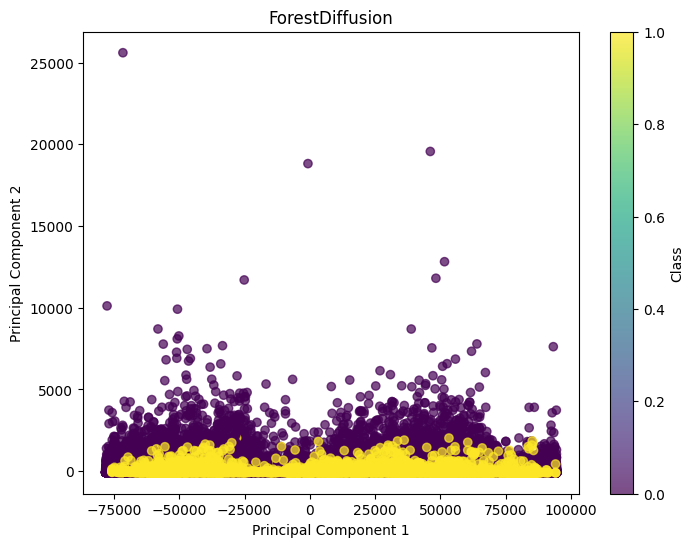

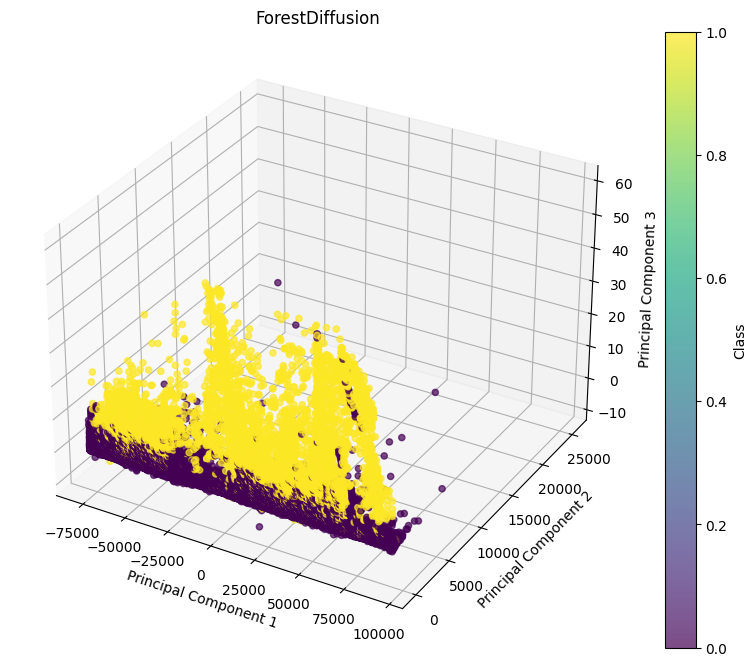


Training Random Forest Classifier...
Random Forest Classifier - Recall (original): 0.8015, Recall (balanced): 0.8858
Random Forest Classifier - F1 (original): 0.8651, F1 (balanced): 0.9317
Number of fake samples generated: 5696


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Step 1: Load the CSV file
file_path = '/kaggle/working/Practice/creditcard.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Apply PCA for visualization (2D and 3D) on the original data
pca_2d_orig = PCA(n_components=2)  # For 2D visualization before augmentation
X_pca_2d_orig = pca_2d_orig.fit_transform(X)

pca_3d_orig = PCA(n_components=3)  # For 3D visualization before augmentation
X_pca_3d_orig = pca_3d_orig.fit_transform(X)

# Step 4: 2D Scatter Plot (before augmentation)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d_orig[:, 0], X_pca_2d_orig[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Original Data')
plt.colorbar(label='Class')
plt.show()

# Step 5: 3D Scatter Plot (before augmentation)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca_3d_orig[:, 0], X_pca_3d_orig[:, 1], X_pca_3d_orig[:, 2], c=y, cmap='viridis', alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('Original Data')
plt.colorbar(sc, label='Class')
plt.show()

# Step 6: Separate the minority class
X_minority = X[y == 1]

# Step 7: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X) // 50)

# Add generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 8: Apply PCA for visualization (2D and 3D) on the augmented data
pca_2d_aug = PCA(n_components=2)  # For 2D visualization after augmentation
X_pca_2d_aug = pca_2d_aug.fit_transform(X_balanced)

pca_3d_aug = PCA(n_components=3)  # For 3D visualization after augmentation
X_pca_3d_aug = pca_3d_aug.fit_transform(X_balanced)

# Step 9: 2D Scatter Plot (after augmentation)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d_aug[:, 0], X_pca_2d_aug[:, 1], c=y_balanced, cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('ForestDiffusion')
plt.colorbar(label='Class')
plt.show()

# Step 10: 3D Scatter Plot (after augmentation)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca_3d_aug[:, 0], X_pca_3d_aug[:, 1], X_pca_3d_aug[:, 2], c=y_balanced, cmap='viridis', alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('ForestDiffusion')
plt.colorbar(sc, label='Class')
plt.show()

# Step 11: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 12: Define Random Forest Classifier
classifier = RandomForestClassifier() 

# Step 13: Train and evaluate the classifier
print(f"\nTraining Random Forest Classifier...")

# Train on original data
classifier.fit(X_train_orig, y_train_orig)
y_pred_orig = classifier.predict(X_test_orig)

# Train on balanced data
classifier.fit(X_train_bal, y_train_bal)
y_pred_bal = classifier.predict(X_test_bal)

# Calculate recall and F1 scores
recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_bal, y_pred_bal)
f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_bal, y_pred_bal)

# Print the performance metrics
print(f"Random Forest Classifier - Recall (original): {recall_orig:.4f}, Recall (balanced): {recall_bal:.4f}")
print(f"Random Forest Classifier - F1 (original): {f1_orig:.4f}, F1 (balanced): {f1_bal:.4f}")

# Step 14: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")


# #Dimensionality Reduction (t-SNE)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE  # Import t-SNE
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Step 1: Load the CSV file
file_path = '/kaggle/working/Practice/creditcard.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Apply t-SNE for visualization (2D and 3D) on the original data
tsne_2d_orig = TSNE(n_components=2, random_state=42)  # For 2D visualization
X_tsne_2d_orig = tsne_2d_orig.fit_transform(X)

tsne_3d_orig = TSNE(n_components=3, random_state=42)  # For 3D visualization
X_tsne_3d_orig = tsne_3d_orig.fit_transform(X)

# Step 4: 2D t-SNE Scatter Plot (before augmentation)
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne_2d_orig[:, 0], X_tsne_2d_orig[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('2D t-SNE Scatter Plot (Before Augmentation)')
plt.colorbar(label='Class')
plt.show()

# Step 5: 3D t-SNE Scatter Plot (before augmentation)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_tsne_3d_orig[:, 0], X_tsne_3d_orig[:, 1], X_tsne_3d_orig[:, 2], c=y, cmap='viridis', alpha=0.7)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.title('3D t-SNE Scatter Plot (Before Augmentation)')
plt.colorbar(sc, label='Class')
plt.show()

# Step 6: Separate the minority class
X_minority = X[y == 1]

# Step 7: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X) // 50)

# Add generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 8: Apply t-SNE for visualization (2D and 3D) on the augmented data
tsne_2d_aug = TSNE(n_components=2, random_state=42)  # For 2D visualization
X_tsne_2d_aug = tsne_2d_aug.fit_transform(X_balanced)

tsne_3d_aug = TSNE(n_components=3, random_state=42)  # For 3D visualization
X_tsne_3d_aug = tsne_3d_aug.fit_transform(X_balanced)

# Step 9: 2D t-SNE Scatter Plot (after augmentation)
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne_2d_aug[:, 0], X_tsne_2d_aug[:, 1], c=y_balanced, cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('2D t-SNE Scatter Plot (After Augmentation)')
plt.colorbar(label='Class')
plt.show()

# Step 10: 3D t-SNE Scatter Plot (after augmentation)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_tsne_3d_aug[:, 0], X_tsne_3d_aug[:, 1], X_tsne_3d_aug[:, 2], c=y_balanced, cmap='viridis', alpha=0.7)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.title('3D t-SNE Scatter Plot (After Augmentation)')
plt.colorbar(sc, label='Class')
plt.show()

# Step 11: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 12: Define Random Forest Classifier
classifier = RandomForestClassifier() 

# Step 13: Train and evaluate the classifier
print(f"\nTraining Random Forest Classifier...")

# Train on original data
classifier.fit(X_train_orig, y_train_orig)
y_pred_orig = classifier.predict(X_test_orig)

# Train on balanced data
classifier.fit(X_train_bal, y_train_bal)
y_pred_bal = classifier.predict(X_test_bal)

# Calculate recall and F1 scores
recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_bal, y_pred_bal)
f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_bal, y_pred_bal)

# Print the performance metrics
print(f"Random Forest Classifier - Recall (original): {recall_orig:.4f}, Recall (balanced): {recall_bal:.4f}")
print(f"Random Forest Classifier - F1 (original): {f1_orig:.4f}, F1 (balanced): {f1_bal:.4f}")

# Step 14: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")


Class distribution before augmentation: {0: 284315, 1: 492}
